In [1]:
#!pip3 install 'pyLDAvis>3,<3.4'

In [2]:
#!pip3 install -U plotly
#!pip3 install -U seaborn
#!pip3 install -U adjustText
#!pip3 uninstall umap -y
#!pip install -U umap-learn

In [3]:
## NBConvert のために
#!pip install -U nbconvert
#!pip install -U pyppeteer

In [4]:
## imports
import sys, os, random, re, glob, copy
import pprint as pp
#import pandas as pd
import pandas as pd
pd.set_option("display.precision", 4)

実行パラメターの設定

In [5]:
## run the follwing once when you use Cython
#!python setup.py clean build_ext --inplace

In [6]:
## Cython を使うかどうか
use_Cython        = False
if use_Cython:
    %load_ext Cython

In [7]:
## 一般設定
verbose           = False
save_data         = False
save_df_sampled   = False

In [8]:
## doc, term の設定
doc_type          = 'word'      # 変更不可
term_size         = 'character' # 変更不可
term_types        = [ '1gram', '2gram', '3gram', '4gram',
                   'skippy2gram', 'skippy3gram', 'skippy4gram' ]  
lda_term_type     = term_types[-1]
print(f"term_type to use: {lda_term_type}")
## doc の最大長と最小長
discard_too_long  = True
max_doc_length    = 15 # effective if discard_too_long is True
discard_too_short = True
min_doc_length    =  5 # effective if discard_too_short is True
## 行の重複を解消する
remove_duplicated_terms = True
## Raw term の濾過: unigram から除外する
remove_highly_frequent_unigrams = True
cutoff_rate             = 0.003 # discard the most frequest terms by <rate>
## 特定形態の除外
remove_stopwords        = False
## カタカナを含む語の除外
discard_kana_overloaded = True
kana_tolerance          = 0.75
## n-gram を包括 (n-gram が (n-1)を真に含む) 型にするかどうか: 包括型にしないと，n が大きくなった時にエンコードされない事例が生じる
ngram_is_inclusive = True
print(f"ngram_is_inclusive: {ngram_is_inclusive}")
ngram_inclusiveness = 2 # この値をdとすると，n-grams は (n-d)まで包括する
## seg_joint
seg_joint = ""
## doc への境界記号の追加
boundary_symbol = "#"
add_boundaries  = False # Likely to cause errors at adjustText
print(f"boundary_symbol: {boundary_symbol}")
print(f"add_boundaries: {add_boundaries}")
## skippy n-gram の記号
gap_mark = "…"
print(f"gap_mark: {gap_mark}")
## skippy n-gram が結びつく最長の gram数: bigram と trigram で共有
max_gap_val = round(max_doc_length * 0.75)
print(f"skippy n-gram max_gap: {max_gap_val}")

term_type to use: skippy4gram
ngram_is_inclusive: True
boundary_symbol: #
add_boundaries: False
gap_mark: …
skippy n-gram max_gap: 11


In [9]:
## LDA の設定
## DTM のterm 濾過の設定
minfreq = 2 # 最低頻度
abuse_threshold = 0.01 # 値が小さい方が濾過力が大きい．0.1 は十分に大きい．
## documents のencoding でLDA を使うか
use_LDA        = True
## topic 数の指定
## 1) term_type が複雑になるほど，多くのtopic が高精度で認識される？
## 2) 連続n-gram なら，topic 数は用語分類が目的であれば，分野数ぐらいが最適？
n_topics       = 30
## alpha の決め方
lda_uses_fixed_alpha = False # Uses 'auto'
lda_alpha_val = 0.01

In [10]:
### FastText 用の設定
## documents のencoding でFastText を使うか: LDA と併用可能
use_FastText  = True
## FT corpus 構築で使う term_type
ft_term_types = [ '1gram', '2gram', '3gram', '4gram', '5gram',
                 'skippy2gram', 'skippy3gram', 'skippy4gram' ]
ft_term_type  = ft_term_types[-1]
## FastText のパラメター window の値: skippy n-gram のn に相当
ft_window_size = 5 # FastText's default value is 5
print(f"FastText creates encoding vectors based on {ft_window_size}-grams of character {ft_term_type}")
## dims（LDA のn_topics に相当）の指定
ft_n_dims_factor = 0.5
ft_n_dims = round(n_topics * ft_n_dims_factor)
## 設定の確認
assert use_LDA or use_FastText
if use_FastText:
    print(f"FastText creates encoding vectors of {ft_n_dims} dimensions")

FastText creates encoding vectors based on 5-grams of character skippy4gram
FastText creates encoding vectors of 15 dimensions


In [11]:
### tSNE の設定
## topic の tSNE 用の設定
top_perplexity_reduct_rate = 0.5
print(f"top_perplexity_rate: {top_perplexity_reduct_rate}")
## doc の tSNE 用の設定
doc_perplexity_reduct_rate1 = 1.0 # topic数に依存する場合
doc_perplexity_reduct_rate2 = 0.2 # doc数に依存する場合
## doc_perplexity を n_topics に基づいて決めるか事例数に基づいて決めるかの選択
doc_perplexity_depends_on_n_topics = False
if doc_perplexity_depends_on_n_topics:
    doc_perplexity_reduc_rate = doc_perplexity_reduct_rate1
else:
    doc_perplexity_reduct_rate = doc_perplexity_reduct_rate2
print(f"doc_perplexity_reduct_rate: {doc_perplexity_reduct_rate}")

top_perplexity_rate: 0.5
doc_perplexity_reduct_rate: 0.2


In [12]:
## UMAP の設定
use_UMAP = True # t-SNE を使った documents の次元圧縮を無効化
## n_neighbours, min_dist の最適化は事前に行ってあるが，変更する事は可能
umap_n_neighbors = 6
umap_min_dist    = 0.2
## 距離指標の選択: このデータに関しては，correlation の他の距離指標は効果的でない
## 事がわかっている
umap_metrics = [    'correlation',  # effective
                    'cosine', 'euclidean', # ineffectives
                    'canberra', 'braycurtis', 'manhattan', 'minkowski', # poor
                    'mahalanobis' # fails
                ]
#
umap_metric = umap_metrics[0]
##
if use_UMAP:
    use_tSNE = False
    print(f"UMAP uses <{umap_metric}> for metric")
else:
    use_tSNE = True

UMAP uses <correlation> for metric


使用データの設定

In [13]:
## 分野の設定
domain_back_encoding = { 0: 'medical', 1: 'mce',
                        2: 'economic', 3: 'juridical', 4: 'publishing', 5: 'cooking',
                        6: 'philosophical', 7: 'buddhist',
                        8: 'other'
                        }
domain_encoding = { v: k for k, v in domain_back_encoding.items() }
domain_names = domain_encoding.keys()
## juridical のデータ拡張をするか
add_juridic2 = True
## 誤用を取り込むか
include_aberrated = True # aberrated medical terms を含めるか
## 解析対象分野の選別
domain_selection = { 'medical'       : True,
                     'mce'           : True,
                     'economic'      : True,
                     'juridical'     : True,
                     'publishing'    : True,
                     'cooking'       : True,
                     'philosophical' : True,
                     'buddhist'      : True
                     }
## 列名の定義
target_vars = [ doc_type ]
target_vars.extend(domain_selection.keys())
print(f"target_vars: {target_vars}")
## 分野の選択
selected_domains = { k: v for k, v in domain_selection.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")
## 注目する分野の指定
target_domain = 'medical'
try:
    assert target_domain in selected_domains.keys()
except AssertionError:
    print(f"target {target_domain} not in selected domains")
## 分野毎の事例数の均衡化
domain_sample_size = 400
if len(selected_domains) > 1:
    balanced = True
else:
    balanced = False
print(f"domain balancing: {balanced} with {domain_sample_size} samples from each domain")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking', 'philosophical', 'buddhist']
selected domains: ['medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking', 'philosophical', 'buddhist']
domain balancing: True with 400 samples from each domain


In [14]:
## colormap の定義: N.B. Plotly go.Scatter_3D(..) では有効でない
used_colors =  [ 'deeppink', 'salmon', 'pink',  'orange', 'green', 'khaki', 'skyblue', 'gray', 'black' ]
colormap = { k : used_colors[k] for k, v in domain_back_encoding.items() if v in selected_domains.keys() }
if verbose:
    print(colormap)
for k, v in colormap.items():
    print(f"分野: {k} {domain_back_encoding[k]}".ljust(20) + " => ".rjust(-10) + f"色: {v}")

分野: 0 medical        => 色: deeppink
分野: 1 mce            => 色: salmon
分野: 2 economic       => 色: pink
分野: 3 juridical      => 色: orange
分野: 4 publishing     => 色: green
分野: 5 cooking        => 色: khaki
分野: 6 philosophical  => 色: skyblue
分野: 7 buddhist       => 色: gray


ファイルを読み込んでデータ構築

In [15]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(sorted(dirs))

In [16]:
## list up files in target directory 
targetdir = "terms-source" # can be changed
files = sorted(list(wd.glob(f"{targetdir}/terms*.xlsx")))
#
print(f"\n{targetdir} contains {len(files)} files to process")
pp.pprint(files)


terms-source contains 9 files to process
[PosixPath('terms-source/terms-cooking-v2a.xlsx'),
 PosixPath('terms-source/terms-economic-v2b.xlsx'),
 PosixPath('terms-source/terms-juridical-v2a.xlsx'),
 PosixPath('terms-source/terms-juridical-v2b.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-errors-v2a.xlsx'),
 PosixPath('terms-source/terms-medical-v2a.xlsx'),
 PosixPath('terms-source/terms-philosophical-v2a.xlsx'),
 PosixPath('terms-source/terms-publishing-v2a.xlsx')]


In [17]:
## 本来のファイルの処理
files_core = [ fn for fn in files if not "juridical-v2b" in str(fn) and not "errors-v" in str(fn) ]
files_core

[PosixPath('terms-source/terms-cooking-v2a.xlsx'),
 PosixPath('terms-source/terms-economic-v2b.xlsx'),
 PosixPath('terms-source/terms-juridical-v2a.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-v2a.xlsx'),
 PosixPath('terms-source/terms-philosophical-v2a.xlsx'),
 PosixPath('terms-source/terms-publishing-v2a.xlsx')]

In [18]:
## 必要に応じて次を実行
#!pip install -U openpyxl
#!conda install openpyxl -y

In [19]:
## ファイルの読み込み
import numpy as np
import pandas as pd

raw_dfs = [ ]
for file in files_core:
    ## 出版用語のsampled = 1 の場合のみ選別
    if "publishing" in str(file):
        d = pd.read_excel(file) # requires openpyxl to be installed
        d = d[d['local.id'] != None]
        d = d[d['unique'] == 1] # 重複出現する語を除外
        d = d[d['sampled'] == 1]
        raw_dfs.append(d)
    else:
        d = pd.read_excel(file)
        d = d[d['local.id'] != None]
        d = d[d['unique'] == 1] # 重複出現する語を除外
        raw_dfs.append(d) # requires openpyxl to be installed
##
raw_dfs

[      local.id        word  unique  medical  mce  economic  juridical  \
 0          1.0      8番らーめん     1.0      0.0  0.0       0.0        0.0   
 1          2.0      ABCスープ     1.0      0.0  0.0       0.0        0.0   
 2          3.0        Aランチ     1.0      0.0  0.0       0.0        0.0   
 3          4.0      BTSサラダ     1.0      0.0  0.0       0.0        0.0   
 4          5.0  SIOコンコーンカツ     1.0      0.0  0.0       0.0        0.0   
 ...        ...         ...     ...      ...  ...       ...        ...   
 4922    4987.0       黒豆サラダ     1.0      0.0  0.0       0.0        0.0   
 4923    4988.0     黒部ダムカレー     1.0      0.0  0.0       0.0        0.0   
 4924    4989.0         龍眼卵     1.0      0.0  0.0       0.0        0.0   
 4925    4990.0      龍馬ギョーザ     1.0      0.0  0.0       0.0        0.0   
 4926    4991.0       龍馬タタキ     1.0      0.0  0.0       0.0        0.0   
 
       publishing  cooking  philosophical  buddhist  valid     rid  subsampled  \
 0            0.0      1.0  

In [20]:
## DataFrame 構築
import unicodedata

check = False
data = pd.DataFrame(columns = target_vars)
dfs = [ ]
for dfx in raw_dfs:
    if check:
        print(dfx)
    try:
        #data.loc[:,target_vars] = dfx[target_vars] # This fails
        data = dfx[target_vars]
    except KeyError:
        data.loc[:,'aberrated'] = 0
    if check:
        print(data)
    dfs.append(data)
## 統合
df0 = pd.concat(dfs)
## check
df0

,word,medical,mce,economic,juridical,publishing,cooking,philosophical,buddhist
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Aランチ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2082,黄板,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2083,黄表紙,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2084,黄金分割,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2085,黒損率,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [21]:
## 追加ファイルの処理
remaining_files = [ file for file in files if not file in files_core ]
print(f"Remaining files: {remaining_files}")

Remaining files: [PosixPath('terms-source/terms-juridical-v2b.xlsx'), PosixPath('terms-source/terms-medical-errors-v2a.xlsx')]


In [22]:
## juridical2 の追加
if add_juridic2:
    juridic2_file = [ fn for fn in remaining_files if "-juridical" in str(fn) ][0]
    print(juridic2_file)
    raw_juridic2 = pd.read_excel(juridic2_file)
    ## juridical の sampled = 1 で unique = 1 の事例のみを選別
    raw_juridic2 = raw_juridic2[ (raw_juridic2['sampled'] == 1) & (raw_juridic2['unique'] == 1) ]
    raw_juridic2 = raw_juridic2[ target_vars ]
    df0 = pd.concat([df0, raw_juridic2])
#
df0

terms-source/terms-juridical-v2b.xlsx


,word,medical,mce,economic,juridical,publishing,cooking,philosophical,buddhist
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Aランチ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
870,訴訟指揮,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
871,上告審,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
874,制限行為能力者,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
875,被控訴人,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
## normalize
df0['word'] = df0['word'].apply(lambda x: unicodedata.normalize("NFKC", str(x)))
df0['word']

0          8番らーめん
1          ABCスープ
2            Aランチ
3          BTSサラダ
4      SIOコンコーンカツ
          ...    
870          訴訟指揮
871           上告審
874       制限行為能力者
875          被控訴人
876          違反調査
Name: word, Length: 12181, dtype: object

In [24]:
## aberrated medical terms の追加
if include_aberrated:
    ## 初期設定
    df0['aberrated'] = 0
    #
    med_error_fn = [ fn for fn in remaining_files if "-errors" in str(fn) ][0]
    raw_errors = pd.read_excel(med_error_fn)
    ## med errors の aberrated = 1 の事例のみを選別
    raw_errors = raw_errors[ raw_errors['aberrated'] == 1 ]
    raw_errors = raw_errors[target_vars]
    n_sample_errors = round( 0.3 * len(raw_errors))
    med_errors = raw_errors.sample(n_sample_errors)
    med_errors['aberrated'] = 1
    med_errors['domain_id'] = 0
    #
    df0 = pd.concat([df0, med_errors])
#
df0

,word,medical,mce,economic,juridical,publishing,cooking,philosophical,buddhist,aberrated,domain_id
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN
2,Aランチ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1667,総胆管瘍,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2425,染区域,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1383,哺乳低下,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3060,耳瘍,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


データの filtering

In [25]:
## 長過ぎる語と短過ぎる語を除外
original_len = len(df0)
if discard_too_long:
    df0 = df0[ [ True if len(str(x)) <= max_doc_length else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they are longer than {max_doc_length}")

if discard_too_short:
    df0 = df0[ [ True if len(str(x)) >= min_doc_length else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they are shorter than {min_doc_length}")

13075: 47 cases are removed because they are longer than 15
6370: 6752 cases are removed because they are shorter than 5


In [26]:
## run the following when need arises
#!pip install -U regex
#!conda install regex -y

In [27]:
## カタカナ/ひらがなを多く含む語の除外
def katakana_count(s: str):
    import regex
    p = regex.compile(r'\p{Script=Katakana}')
    return len(p.findall(s))

def hiragana_count(s: str):
    import regex
    p = regex.compile(r'\p{Script=Hiragana}')
    return len(p.findall(s))
#
original_len = len(df0)    
if discard_kana_overloaded:
    ## katakana
    df0 = df0[ [ True if katakana_count(str(x))/len(str(x)) <= kana_tolerance else False for x in df0[doc_type] ] ]
    ## hiragana
    df0 = df0[ [ True if hiragana_count(str(x))/len(str(x)) <= kana_tolerance else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because of too many kana characters")

5080: 1290 cases are removed because of too many kana characters


In [28]:
## 色分けの為の domain_id を定義
check = False
domain_id_list = [ ]
for i, row in df0.iterrows():
    ## specific domains
    if   row['medical']       == 1: domain_id_list.append(domain_encoding['medical'])
    elif row['mce']           == 1: domain_id_list.append(domain_encoding['mce'])
    elif row['economic']      == 1: domain_id_list.append(domain_encoding['economic'])
    elif row['juridical']     == 1: domain_id_list.append(domain_encoding['juridical'])
    elif row['publishing']    == 1: domain_id_list.append(domain_encoding['publishing'])
    elif row['cooking']       == 1: domain_id_list.append(domain_encoding['cooking'])
    elif row['philosophical'] == 1: domain_id_list.append(domain_encoding['philosophical'])
    elif row['buddhist']      == 1:
        if 'buddhist' in selected_domains:
            domain_id_list.append(domain_encoding['buddhist'])
        else:
            domain_id_list.append(domain_encoding['philosophical'])
    ## all others
    else:
        domain_id_list.append(domain_encoding['other'])

## domain_id 列の追加
df0['domain_id'] = domain_id_list

## domain 列の追加
df0['domain'] = df0['domain_id'].apply(lambda x: domain_back_encoding[x])

## domain の事例数の確認
df0['domain'].value_counts().sort_index()

domain
cooking          1515
economic          241
juridical         199
mce               426
medical          2348
philosophical      26
publishing        325
Name: count, dtype: int64

In [29]:
## 重複の削除
if remove_duplicated_terms:
    df0 = df0.drop_duplicates(subset = [doc_type], keep = 'first')

In [30]:
## 分野の事例数の確認
print(f"selected domains")
#S = [ ]
for domain_name in selected_domains.keys():
    print(f"domain_name: {domain_name}")
    S = df0[df0[domain_name] == 1]
    S.loc[:,'domain'] = domain_name
df0

selected domains
domain_name: medical
domain_name: mce
domain_name: economic
domain_name: juridical
domain_name: publishing
domain_name: cooking
domain_name: philosophical
domain_name: buddhist


,word,medical,mce,economic,juridical,publishing,cooking,philosophical,buddhist,aberrated,domain_id,domain
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,cooking
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,cooking
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,cooking
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,cooking
8,アイス抹茶ラテ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,cooking
...,...,...,...,...,...,...,...,...,...,...,...,...
3485,精神発遅滞,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,medical
134,ビタミンB2欠乏症,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,medical
137,中指中節骨端線損傷,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,medical
67,糖尿病性多発ニュロパチー,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,medical


In [31]:
## 分野指定の整合性の確認
#effective_vars = [ 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking' ]
#domain_names = id2domaing_mapping.values()
effective_vars = [ x for x in domain_names if x != 'other' ]
df0['checksum'] = df0[effective_vars].sum(axis = 1, skipna = True)
print(f"count of checksum == 0: {len(df0[df0['checksum'] == 0])}")
print(f"count of checksum  > 1: {len(df0[df0['checksum'] > 1])}")

count of checksum == 0: 0
count of checksum  > 1: 1


Balancing data

In [32]:
## 混合のための割合を調整:　事例数を揃えるために復元抽出の設定にしているので事例の重複が起きる
if balanced:
    # Medical
    if 'medical' in selected_domains.keys():
        med_sampled = df0[ df0['medical'] == 1 ].sample(domain_sample_size, replace = False)
    else:
        med_sampled = None
    # MCE
    if 'mce' in selected_domains.keys():
        mce_sampled = df0[ df0['mce'] == 1 ].sample(domain_sample_size, replace = False)
    else:
        mce_sampled = None
    # Economical
    if 'economic' in selected_domains.keys():
        econo_sampled = df0[ df0['economic'] == 1 ]
    else:
        econo_sampled = None
    # Juridical
    if 'juridical' in selected_domains.keys():
        jurid_sampled = df0[ df0['juridical'] == 1 ].sample(domain_sample_size, replace = True)
    else:
        jurid_sampled = None
    # Publishing
    if 'publishing' in selected_domains.keys():
        pub_sampled = df0[ df0['publishing'] == 1 ].sample(domain_sample_size, replace = True)
    else:
        pub_sampled = None
    # Cooking
    if 'cooking' in selected_domains.keys():
        cook_sampled = df0[ df0['cooking'] == 1 ].sample(domain_sample_size, replace = False)
    else:
        cook_sampled = None
    # Philosophical
    if 'philosophical' in selected_domains.keys():
        philo_sampled = df0[ df0['philosophical'] == 1 ]
    else:
        philo_sampled = None
    # Buddhist
    if 'buddhist' in selected_domains.keys():
        budd_sampled = df0[ df0['buddhist'] == 1 ]
    else:
        budd_sampled = None
    ## integration
    df0 = pd.concat([med_sampled, mce_sampled, econo_sampled, jurid_sampled, pub_sampled,
                     cook_sampled, philo_sampled, budd_sampled ])

## domain の事例数の確認
df0['domain_id'].value_counts(sort = True).sort_index()

domain_id
0    400
1    400
2    241
3    400
4    400
5    400
6     27
Name: count, dtype: int64

In [33]:
## 順序をランダマイズし df0 を df として再定義
import sklearn.utils
df = sklearn.utils.shuffle(df0)

In [34]:
## 設定の確認
df[[doc_type, 'domain_id', 'checksum']]

,word,domain_id,checksum
4475,豆腐ラーメン,5,1.0
1347,差し替え番号,4,1.0
585,新株予約権売渡請求,3,1.0
576,金融商品取引業協会,3,1.0
756,運動プログラム,1,1.0
...,...,...,...
2862,自己免疫性膵炎,0,1.0
47,OVER気味,1,1.0
1653,なめろう軍艦,5,1.0
129,担保権の消滅,3,1.0


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_7101/459730398.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


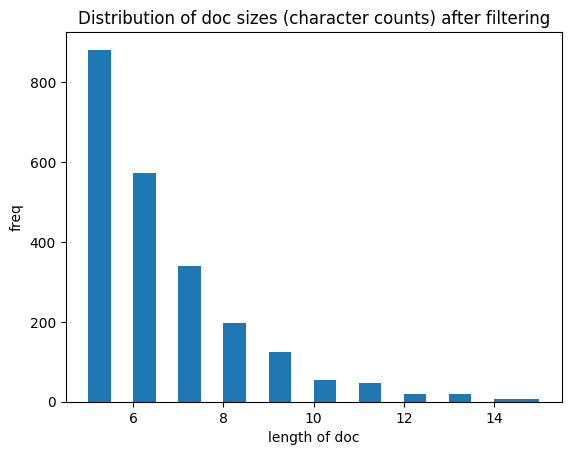

In [35]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

d = [ len(x) for x in df[doc_type] ]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(d, bins = 20)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of doc sizes (character counts) after filtering")
fig.show()

DTM 構築

In [36]:
## 境界記号の追加
if add_boundaries:
    df[doc_type] = df[doc_type].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")

In [37]:
## 共有される名称の定義
docs = df[doc_type]
docs

4475       豆腐ラーメン
1347       差し替え番号
585     新株予約権売渡請求
576     金融商品取引業協会
756       運動プログラム
          ...    
2862      自己免疫性膵炎
47         OVER気味
1653       なめろう軍艦
129        担保権の消滅
3473      高血圧性腎不全
Name: word, Length: 2268, dtype: object

In [38]:
## 1-gram 生成
unigrams = [ ]
check = False
for x in docs:
    if check:
        print(x)
    u = list(x)
    if len(u) > 0:
        unigrams.append(u)
#
random.sample(unigrams, 10)

[['B', 'a', 'g', 'g', 'i', 'n', 'g', '対', '応'],
 ['足', '底', '部', '腫', '瘍'],
 ['横', '三', '方', '化', '粧'],
 ['ア', 'キ', 'レ', 'ス', '腱', '挫', '傷'],
 ['ア', 'プ', 'レ', 'ゾ', 'リ', 'ン', '使', '用'],
 ['遺', '伝', '性', '角', '膜', 'ジ', 'ス', 'ト', 'ロ', 'フ', 'ィ', 'ー'],
 ['稲', '庭', 'う', 'ど', 'ん'],
 ['成', '型', '溝', '付', '機'],
 ['血', '糖', '降', '下', '作', '用'],
 ['先', '天', '性', '尿', '道', '弁']]

In [39]:
## 1-gram の頻度を取得
import collections
unigrams_all = [ ]
[ unigrams_all.extend(L) for L in unigrams ]
unigram_freqs = collections.Counter(unigrams_all)
unigram_freqs.most_common(20)

[('ー', 399),
 ('の', 274),
 ('性', 223),
 ('ン', 214),
 ('ル', 136),
 ('ス', 126),
 ('し', 125),
 ('り', 119),
 ('き', 112),
 ('ラ', 99),
 ('ロ', 79),
 ('ッ', 79),
 ('ト', 76),
 ('ん', 76),
 ('ク', 75),
 ('リ', 72),
 ('ア', 72),
 ('炎', 71),
 ('権', 70),
 ('機', 70)]

In [40]:
## 高頻度 1-gram フィルターの産物を確認
highly_frequents = sorted(unigram_freqs, reverse = True)[:round(cutoff_rate * len(unigrams))]
highly_frequents

['龍', '齢', '鼻', '鼡', '鼠', '鼓', '黒']

高頻度文字 1-grams を除外

In [41]:
## 高頻度 1-gram の除外
if remove_highly_frequent_unigrams:
    unigrams = [ g for g in unigrams if not g in highly_frequents ]
    print(f"{len(highly_frequents)} unigrams were removed due to high frequency")
else:
    print(f"{len(highly_frequents)} unigrams were not removed")

7 unigrams were removed due to high frequency


In [42]:
## 名称の設定
df['1gram'] = unigrams
df['1gram']

4475             [豆, 腐, ラ, ー, メ, ン]
1347             [差, し, 替, え, 番, 号]
585     [新, 株, 予, 約, 権, 売, 渡, 請, 求]
576     [金, 融, 商, 品, 取, 引, 業, 協, 会]
756           [運, 動, プ, ロ, グ, ラ, ム]
                   ...             
2862          [自, 己, 免, 疫, 性, 膵, 炎]
47               [O, V, E, R, 気, 味]
1653             [な, め, ろ, う, 軍, 艦]
129              [担, 保, 権, の, 消, 滅]
3473          [高, 血, 圧, 性, 腎, 不, 全]
Name: 1gram, Length: 2268, dtype: object

# n-gram (n > 1) の生成

In [43]:
## generic function for n-gram generation
def add_ngram_to_df(dfx, n_for_ngram: int, var_prefix: str = "", ngram_is_skippy: bool = False, ngram_is_inclusive: bool = ngram_is_inclusive, ngram_inclusiveness: int = ngram_inclusiveness, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    inclusion_size = (n_for_ngram - ngram_inclusiveness)
    print(f"inclusion_size: {inclusion_size}")
    assert inclusion_size >= 0
    source_var = f"{var_prefix}1gram"
    print(f"source_var: {source_var}")
    unigrams = df[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if ngram_is_skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, check = False)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, check = False)] for x in unigrams ]
    else:
        import gen_ngrams
        if ngram_is_skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = "", check = False) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = "", check = False) for x in unigrams ]
    ## 包括的 n-gramの生成
    if ngram_is_inclusive:
        assert (n_for_ngram - 1) > 0
        supplement_var = f"{var_prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            included = [ x for x in list(dfx[supplement_var])[i] if len(x) >= inclusion_size ]
            if len(included) > 0:
                g.extend(included)
    ## 変数の追加
    if ngram_is_skippy and n_for_ngram > 2:
        added_var = f"{var_prefix}skippy{n_for_ngram}gram"
    else:
        added_var = f"{var_prefix}{n_for_ngram}gram"
    print(f"added_var: {added_var}")
    dfx[added_var] = ngrams
    ## check result
    print(dfx[added_var])

In [44]:
## 2-gram 生成
add_ngram_to_df(df, n_for_ngram = 2, ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = 1, use_Cython = use_Cython, check = True)

inclusion_size: 1
source_var: 1gram
supplement_var: 1gram
added_var: 2gram
4475               [豆腐, 腐ラ, ラー, ーメ, メン, 豆, 腐, ラ, ー, メ, ン]
1347               [差し, し替, 替え, え番, 番号, 差, し, 替, え, 番, 号]
585     [新株, 株予, 予約, 約権, 権売, 売渡, 渡請, 請求, 新, 株, 予, 約, 権...
576     [金融, 融商, 商品, 品取, 取引, 引業, 業協, 協会, 金, 融, 商, 品, 取...
756         [運動, 動プ, プロ, ログ, グラ, ラム, 運, 動, プ, ロ, グ, ラ, ム]
                              ...                        
2862        [自己, 己免, 免疫, 疫性, 性膵, 膵炎, 自, 己, 免, 疫, 性, 膵, 炎]
47                 [OV, VE, ER, R気, 気味, O, V, E, R, 気, 味]
1653               [なめ, めろ, ろう, う軍, 軍艦, な, め, ろ, う, 軍, 艦]
129                [担保, 保権, 権の, の消, 消滅, 担, 保, 権, の, 消, 滅]
3473        [高血, 血圧, 圧性, 性腎, 腎不, 不全, 高, 血, 圧, 性, 腎, 不, 全]
Name: 2gram, Length: 2268, dtype: object


In [45]:
## skippy 2-gram 生成
add_ngram_to_df(df, n_for_ngram = 2, ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = 1, use_Cython = use_Cython, check = True)

inclusion_size: 1
source_var: 1gram
supplement_var: 1gram
added_var: 2gram
4475    [豆腐, 豆…ラ, 豆…ー, 豆…メ, 豆…ン, 腐ラ, 腐…ー, 腐…メ, 腐…ン, ラー...
1347    [差し, 差…替, 差…え, 差…番, 差…号, し替, し…え, し…番, し…号, 替え...
585     [新株, 新…予, 新…約, 新…権, 新…売, 新…渡, 新…請, 新…求, 株予, 株…...
576     [金融, 金…商, 金…品, 金…取, 金…引, 金…業, 金…協, 金…会, 融商, 融…...
756     [運動, 運…プ, 運…ロ, 運…グ, 運…ラ, 運…ム, 動プ, 動…ロ, 動…グ, 動…...
                              ...                        
2862    [自己, 自…免, 自…疫, 自…性, 自…膵, 自…炎, 己免, 己…疫, 己…性, 己…...
47      [OV, O…E, O…R, O…気, O…味, VE, V…R, V…気, V…味, ER...
1653    [なめ, な…ろ, な…う, な…軍, な…艦, めろ, め…う, め…軍, め…艦, ろう...
129     [担保, 担…権, 担…の, 担…消, 担…滅, 保権, 保…の, 保…消, 保…滅, 権の...
3473    [高血, 高…圧, 高…性, 高…腎, 高…不, 高…全, 血圧, 血…性, 血…腎, 血…...
Name: 2gram, Length: 2268, dtype: object


In [46]:
## 3-gram 生成
add_ngram_to_df(df, n_for_ngram = 3, ngram_is_skippy = False,  ngram_is_inclusive = True, ngram_inclusiveness = 1, use_Cython = use_Cython, check = True)

inclusion_size: 2
source_var: 1gram
supplement_var: 2gram
added_var: 3gram
4475    [豆腐ラ, 腐ラー, ラーメ, ーメン, 豆腐, 豆…ラ, 豆…ー, 豆…メ, 豆…ン, 腐...
1347    [差し替, し替え, 替え番, え番号, 差し, 差…替, 差…え, 差…番, 差…号, し...
585     [新株予, 株予約, 予約権, 約権売, 権売渡, 売渡請, 渡請求, 新株, 新…予, 新...
576     [金融商, 融商品, 商品取, 品取引, 取引業, 引業協, 業協会, 金融, 金…商, 金...
756     [運動プ, 動プロ, プログ, ログラ, グラム, 運動, 運…プ, 運…ロ, 運…グ, 運...
                              ...                        
2862    [自己免, 己免疫, 免疫性, 疫性膵, 性膵炎, 自己, 自…免, 自…疫, 自…性, 自...
47      [OVE, VER, ER気, R気味, OV, O…E, O…R, O…気, O…味, V...
1653    [なめろ, めろう, ろう軍, う軍艦, なめ, な…ろ, な…う, な…軍, な…艦, め...
129     [担保権, 保権の, 権の消, の消滅, 担保, 担…権, 担…の, 担…消, 担…滅, 保...
3473    [高血圧, 血圧性, 圧性腎, 性腎不, 腎不全, 高血, 高…圧, 高…性, 高…腎, 高...
Name: 3gram, Length: 2268, dtype: object


In [47]:
## skippy 3-gram 生成
add_ngram_to_df(df, n_for_ngram = 3, ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = 1, use_Cython = use_Cython, check = True)

inclusion_size: 2
source_var: 1gram
supplement_var: 2gram
added_var: skippy3gram
4475    [豆腐ラ, 豆腐…ー, 豆腐…メ, 豆腐…ン, 豆…ラー, 豆…ラ…メ, 豆…ラ…ン, 豆…...
1347    [差し替, 差し…え, 差し…番, 差し…号, 差…替え, 差…替…番, 差…替…号, 差…...
585     [新株予, 新株…約, 新株…権, 新株…売, 新株…渡, 新株…請, 新株…求, 新…予約...
576     [金融商, 金融…品, 金融…取, 金融…引, 金融…業, 金融…協, 金融…会, 金…商品...
756     [運動プ, 運動…ロ, 運動…グ, 運動…ラ, 運動…ム, 運…プロ, 運…プ…グ, 運…プ...
                              ...                        
2862    [自己免, 自己…疫, 自己…性, 自己…膵, 自己…炎, 自…免疫, 自…免…性, 自…免...
47      [OVE, OV…R, OV…気, OV…味, O…ER, O…E…気, O…E…味, O…...
1653    [なめろ, なめ…う, なめ…軍, なめ…艦, な…ろう, な…ろ…軍, な…ろ…艦, な…...
129     [担保権, 担保…の, 担保…消, 担保…滅, 担…権の, 担…権…消, 担…権…滅, 担…...
3473    [高血圧, 高血…性, 高血…腎, 高血…不, 高血…全, 高…圧性, 高…圧…腎, 高…圧...
Name: skippy3gram, Length: 2268, dtype: object


In [48]:
## 4-gram 生成
add_ngram_to_df(df, n_for_ngram = 4, ngram_is_skippy = False,  ngram_is_inclusive = True, ngram_inclusiveness = 1, use_Cython = use_Cython, check = True)

inclusion_size: 3
source_var: 1gram
supplement_var: 3gram
added_var: 4gram
4475    [豆腐ラー, 腐ラーメ, ラーメン, 豆腐ラ, 腐ラー, ラーメ, ーメン, 豆…ラ, 豆…...
1347    [差し替え, し替え番, 替え番号, 差し替, し替え, 替え番, え番号, 差…替, 差…...
585     [新株予約, 株予約権, 予約権売, 約権売渡, 権売渡請, 売渡請求, 新株予, 株予約,...
576     [金融商品, 融商品取, 商品取引, 品取引業, 取引業協, 引業協会, 金融商, 融商品,...
756     [運動プロ, 動プログ, プログラ, ログラム, 運動プ, 動プロ, プログ, ログラ, グ...
                              ...                        
2862    [自己免疫, 己免疫性, 免疫性膵, 疫性膵炎, 自己免, 己免疫, 免疫性, 疫性膵, 性...
47      [OVER, VER気, ER気味, OVE, VER, ER気, R気味, O…E, O…...
1653    [なめろう, めろう軍, ろう軍艦, なめろ, めろう, ろう軍, う軍艦, な…ろ, な…...
129     [担保権の, 保権の消, 権の消滅, 担保権, 保権の, 権の消, の消滅, 担…権, 担…...
3473    [高血圧性, 血圧性腎, 圧性腎不, 性腎不全, 高血圧, 血圧性, 圧性腎, 性腎不, 腎...
Name: 4gram, Length: 2268, dtype: object


In [49]:
## skippy 4-gram 生成
add_ngram_to_df(df, n_for_ngram = 4, ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = 1, use_Cython = use_Cython, check = True)

inclusion_size: 3
source_var: 1gram
supplement_var: 3gram
added_var: skippy4gram
4475    [豆腐ラー, 豆腐ラ…メ, 豆腐ラ…ン, 豆腐…ーメ, 豆腐…ー…ン, 豆腐…メン, 豆…ラ...
1347    [差し替え, 差し替…番, 差し替…号, 差し…え番, 差し…え…号, 差し…番号, 差…替...
585     [新株予約, 新株予…権, 新株予…売, 新株予…渡, 新株予…請, 新株予…求, 新株…約...
576     [金融商品, 金融商…取, 金融商…引, 金融商…業, 金融商…協, 金融商…会, 金融…品...
756     [運動プロ, 運動プ…グ, 運動プ…ラ, 運動プ…ム, 運動…ログ, 運動…ロ…ラ, 運動…...
                              ...                        
2862    [自己免疫, 自己免…性, 自己免…膵, 自己免…炎, 自己…疫性, 自己…疫…膵, 自己…...
47      [OVER, OVE…気, OVE…味, OV…R気, OV…R…味, OV…気味, O…E...
1653    [なめろう, なめろ…軍, なめろ…艦, なめ…う軍, なめ…う…艦, なめ…軍艦, な…ろ...
129     [担保権の, 担保権…消, 担保権…滅, 担保…の消, 担保…の…滅, 担保…消滅, 担…権...
3473    [高血圧性, 高血圧…腎, 高血圧…不, 高血圧…全, 高血…性腎, 高血…性…不, 高血…...
Name: skippy4gram, Length: 2268, dtype: object


In [50]:
## 使ったデータの保存
if save_data:
    import datetime as dt
    ct = dt.datetime.now()
    ## Pandas で .csv として
    output_fn1 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".csv"
    print(f"saving data to {output_fn1}")
    import pandas as pd
    df.to_csv(output_fn1)
    ## pickle.dump(..)で
    output_fn2 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".p"
    import pickle
    print(f"saving data to {output_fn2}")
    with open(output_fn2, "wb") as f:
        pickle.dump(df, f)

In [51]:
## 解析対象の確認
## aberrated == 1 は訓練事例に含めない
bots = df[df['aberrated'] == 0][lda_term_type]
bots

4475    [豆腐ラー, 豆腐ラ…メ, 豆腐ラ…ン, 豆腐…ーメ, 豆腐…ー…ン, 豆腐…メン, 豆…ラ...
1347    [差し替え, 差し替…番, 差し替…号, 差し…え番, 差し…え…号, 差し…番号, 差…替...
585     [新株予約, 新株予…権, 新株予…売, 新株予…渡, 新株予…請, 新株予…求, 新株…約...
576     [金融商品, 金融商…取, 金融商…引, 金融商…業, 金融商…協, 金融商…会, 金融…品...
756     [運動プロ, 運動プ…グ, 運動プ…ラ, 運動プ…ム, 運動…ログ, 運動…ロ…ラ, 運動…...
                              ...                        
2862    [自己免疫, 自己免…性, 自己免…膵, 自己免…炎, 自己…疫性, 自己…疫…膵, 自己…...
47      [OVER, OVE…気, OVE…味, OV…R気, OV…R…味, OV…気味, O…E...
1653    [なめろう, なめろ…軍, なめろ…艦, なめ…う軍, なめ…う…艦, なめ…軍艦, な…ろ...
129     [担保権の, 担保権…消, 担保権…滅, 担保…の消, 担保…の…滅, 担保…消滅, 担…権...
3473    [高血圧性, 高血圧…腎, 高血圧…不, 高血圧…全, 高血…性腎, 高血…性…不, 高血…...
Name: skippy4gram, Length: 2215, dtype: object

In [52]:
## stopwords を除外
stopwords = [ '腫瘍', '性', '炎', '血', '腫', '瘍', 'の' ]
if remove_stopwords:
    bows = [ [ x for x in bot if x not in stopwords ] for bot in bots ]
if verbose:
    random.sample(list(bots), 3)

# LDA

In [53]:
## LDA 構築の基になる dictionary = document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)
## 結果の確認
print(diction)

Dictionary<113246 unique tokens: ['ラ…メ', 'ラ…ン', 'ラーメ', 'ラーメン', 'ー…ン']...>


In [54]:
## 構造の確認
for k in random.sample(diction.keys(), 20):
    print(f"index: {k} ; term: {diction[k]}")

index: 8028 ; term: ロ…ス…ミ…ル
index: 100440 ; term: 表…除去…覆
index: 87767 ; term: 飛…自
index: 113173 ; term: OV…R気
index: 40163 ; term: ネ…イ
index: 98133 ; term: 右肺…再…変
index: 63445 ; term: 解…サ
index: 16737 ; term: の…辛
index: 42604 ; term: 不利益…事
index: 21903 ; term: ンゲル
index: 3187 ; term: ッ…粒
index: 31446 ; term: 横…ア修復
index: 26001 ; term: 特発性捻
index: 106418 ; term: し…ゃ…ポ…ト
index: 111447 ; term: 髄…菌…腎…候
index: 59205 ; term: 南ア…国連
index: 14001 ; term: き…こ…スー
index: 91648 ; term: ぼ…ゃ…ュ…ダ
index: 71764 ; term: ー…注
index: 17404 ; term: 加…テ…シ…ン


In [55]:
## diction の検査
import pandas as pd
from operator import attrgetter
from collections import namedtuple
freq_record = namedtuple('record', ['term', 'freq'])
term_freqs = [ freq_record(*x) for x in diction.most_common() ] ## most_common allows access to frequencies
terms_freqs = sorted(term_freqs, key = attrgetter('freq'), reverse = True)
## term の頻度順位で上位30件
term_freqs[:20]

[record(term='ー…ー', freq=94),
 record(term='ー…ン', freq=72),
 record(term='性…炎', freq=38),
 record(term='ー…ル', freq=35),
 record(term='ル…ー', freq=33),
 record(term='ス…ー', freq=32),
 record(term='ク…ー', freq=31),
 record(term='ン…ー', freq=29),
 record(term='の…き', freq=28),
 record(term='の…ー', freq=28),
 record(term='ラ…ン', freq=27),
 record(term='性…症', freq=27),
 record(term='カ…ー', freq=26),
 record(term='フ…ー', freq=23),
 record(term='ト…ー', freq=22),
 record(term='見…し', freq=22),
 record(term='先…性', freq=22),
 record(term='先天性', freq=22),
 record(term='ラ…メ', freq=21),
 record(term='ラーメ', freq=21)]

In [56]:
## 頻度1 のterm の個数
hapaxes = [ record for record in term_freqs if record.freq == 1]
hapax_counts = {len(hapaxes)}
## 頻度1 の term のサンプルn件
hapax_sample_n = 20
print(f"{hapax_sample_n} samples")
pp.pprint(random.sample(hapaxes, hapax_sample_n))
## 個数
print(f"number of hapaxes: {hapax_counts}")

20 samples
[record(term='新…工…地域', freq=1),
 record(term='人工水…眼', freq=1),
 record(term='酸…?…和度', freq=1),
 record(term='性アル…シ', freq=1),
 record(term='不…全…腎…管', freq=1),
 record(term='化…れ…商…理', freq=1),
 record(term='死念慮発', freq=1),
 record(term='鯖…韓', freq=1),
 record(term='のケ…プ…め', freq=1),
 record(term='gr…u…e', freq=1),
 record(term='症候性…毛', freq=1),
 record(term='エ…テー…ョ', freq=1),
 record(term='運動…遅滞', freq=1),
 record(term='うっ…心…全', freq=1),
 record(term='き…の…ラダ', freq=1),
 record(term='くろ…茶豆', freq=1),
 record(term='済…構', freq=1),
 record(term='茄…の…揚げ', freq=1),
 record(term='テ…ト…a…n', freq=1),
 record(term='造…流', freq=1)]
number of hapaxes: {91291}


In [57]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction) # 予備の生成
## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq, no_above = abuse_threshold)
print(diction_copy)

Dictionary<20098 unique tokens: ['ラ…メ', 'ラーメ', 'ラーメン', 'ーメン', '豆…メ']...>


In [58]:
## データを選択
diction = diction_copy # 名前を元に戻す
## gensim の用 corpusの構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
corpus_sample_n = 1
print(f"{corpus_sample_n} samples")
pp.pprint(random.sample(corpus, corpus_sample_n))
print(f"Number of documents: {len(corpus)}")

1 samples
[[(12849, 1), (12850, 1)]]
Number of documents: 2215


LDA を実行

In [59]:
## LDA モデルの構築
from gensim.models import LdaModel
if lda_uses_fixed_alpha:
    doc_lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = lda_alpha_val)
else:
    doc_lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 'auto')
print(doc_lda)

LdaModel<num_terms=20098, num_topics=30, decay=0.5, chunksize=2000>


In [60]:
## 結果の検査
sample_n = 3
for doc in random.sample(list(df[doc_type]), sample_n):
    print(doc)
    p_dist = doc_lda.get_document_topics(diction.doc2bow([f"{doc}"]), minimum_probability = 0)
    print(p_dist)
    print(f"sums up to: {sum(p_dist[-1]):0.3f} over {len(p_dist)} topics")

債権者の一般の利益
[(0, 0.032482438), (1, 0.033903293), (2, 0.03336055), (3, 0.03230505), (4, 0.033084337), (5, 0.033253346), (6, 0.033453926), (7, 0.033215877), (8, 0.03315712), (9, 0.033028863), (10, 0.033556707), (11, 0.033359803), (12, 0.033321597), (13, 0.032835275), (14, 0.03323617), (15, 0.033549722), (16, 0.033995315), (17, 0.033395573), (18, 0.033318404), (19, 0.032823037), (20, 0.03350759), (21, 0.033898123), (22, 0.033471666), (23, 0.033644013), (24, 0.03335849), (25, 0.033664748), (26, 0.033221845), (27, 0.03407135), (28, 0.03266575), (29, 0.033860028)]
sums up to: 29.034 over 30 topics
差し込み機
[(0, 0.032482438), (1, 0.033903293), (2, 0.03336055), (3, 0.03230505), (4, 0.033084337), (5, 0.033253346), (6, 0.033453926), (7, 0.033215877), (8, 0.03315712), (9, 0.033028863), (10, 0.033556707), (11, 0.033359803), (12, 0.033321597), (13, 0.032835275), (14, 0.03323617), (15, 0.033549722), (16, 0.033995315), (17, 0.033395573), (18, 0.033318404), (19, 0.032823037), (20, 0.03350759), (21, 0.03389

LDAvis の実行

In [61]:
%%capture --no-display
## pyLDAvis を使った結果 D_lda の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")
#
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction
## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS = False
LDAvis_use_tsne = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds', n_jobs = 1, sort_topics = False)
elif LDAvis_use_tsne:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [62]:
%%capture --no-display
## lda のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)
## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,...,topic 21,topic 22,topic 23,topic 24,topic 25,topic 26,topic 27,topic 28,topic 29,topic 30
0,紙の…強さ,高…性,んにゃく,ク…ス,皮膚炎,バ…ー,S…I,裁判所,被…者,先天性,...,高…波シー,本…の,れ…紙,り…サラダ,フ…ー,イ…ー,煮込み,の…え,逆…と…紙…み,性膵炎
1,の…強,血…性,こ…にゃく,ち…わ,皮…炎,C…直,S…ag…I,裁…所,膜…症,先…性,...,高周…ール,金…額,キ…ン,り…サ,クロス,ロ…ー,煮…み,り…テ,中…じ…紙…る,前立腺
2,紙…強,ー…リ,ん…ゃ,レザー・,せ丁合,E…直,Sta…I,ーパー,面アー,の…な,...,高…波,資…額,仕…書,り…ダ,ス…紙,採用…知書,バ…ル,処…の,逆…じ…く…み,前…腺
3,紙の…裂…さ,高…圧,こんに…く,レザ…クロ,合…い,総…産,St…g…I,ジ…ー,面…ー,合…せ,...,周…ル,資本金,製…仕,ア…ス,ク…ス,採…内定…書,本…合,ゃ…ラ,逆…と,し…り
4,裂…さ,高血圧性,こ…に,レ…ー…ロス,合…丁,国…総,tag…I,の3原,アート,合わせ,...,高…ー,資…金,金…市,マ…ン,天…ア,内…通,新生…呼吸,ゃ…ダ,逆…とじ…み,詐害営業
5,の…さ,血圧性,こ…ゃ,ー・ク,合…合,総生産,t…I,色の3原,両面…ート,先…角,...,周波シー,金の額,れ革表,ー…紙,先…ア,採用内…通,判…請,ゃ…サラダ,逆…じ…くる,詐…営業…渡
6,紙…さ,高血圧,に…く,レ…ー・…ロ,わせ丁,国…総生産,a…I,破…判,両…ト,天…膜,...,高…波シ…ル,本金の,仕様書,定…事,障…金,採…内…通…書,判上の…求,ゃ…サ,逆…じ…るみ,害営業譲
7,の…裂,血…全,にゃく,レ…ー・ク,わ…い,性…視,g…I,色…3原色,両…ア,先天性…膜,...,高…ル,資本…の額,製本仕,選定当,害…金,採…内,生…吸,り…ラ,ー…パルプ,業…渡
8,紙…裂,性…不,こんにゃ,ザー…ク…ス,せ…い,り…り,t…g…II,破…裁,両面アー,先…膜,...,周波シ…ル,資…金の額,製本仕…書,選…当,ク…ー,用内定通,裁…の請求,の訴え,ー…パ,詐…譲
9,整…続,血…性…不全,こ…く,レザ…・ク,合わせ,レ…機,age…I,の…原,ア…ト,先天…角膜,...,高周波…ル,資本金の,期金融,定当事,将…の…求権,用内…通…書,生児…呼吸,豆…の,ー…プ,害営業


# Topics のクラスタリング

In [63]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()
if check:
    random.sample(list(topic_dist), 5)

In [64]:
## 検査 1: topic ごとに分布の和を取る
topic_dist.sum(axis = 1)

array([0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       1.0000001 , 0.9999999 , 1.        , 0.9999999 , 1.        ],
      dtype=float32)

In [65]:
## 検査 2: 総和を求める: n_topics に (ほぼ) 等しいなら正常
round(topic_dist.sum())

30

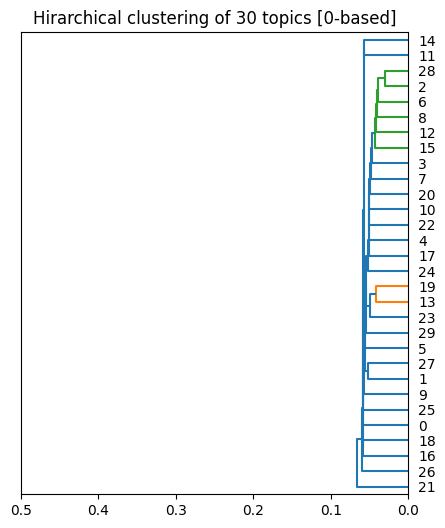

In [66]:
## topic の階層クラスタリング
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
## 作図範囲の指定
plt.figure(figsize = (5, 6))
## 距離行列の生成
topic_linkage = linkage(topic_dist, method = 'ward', metric = 'euclidean')
dendrogram(topic_linkage, orientation = 'left')
## 作図
plt.xlim(0.5, 0) # 異なる分析に比較を楽にするために，x軸の大きさを固定
plt.title(f"Hirarchical clustering of {n_topics} topics [0-based]")
plt.show()

In [67]:
## tSNE を使った topic のクラスタリング
import sklearn.manifold
## 必要に応じて reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)
## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い
relative = True
if relative:
    #top_perplexity_reduct_rate = 0.5 # 定義は先頭に移動
    top_perplexity_val = round(n_topics * top_perplexity_reduct_rate)
else:
    top_perplexity_val = 5 # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
## 3D version
top_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = top_perplexity_val, n_iter = 1000)

top_perplexity_val: 15


In [68]:
## topic_dist データに適用 topic_dist のグループ化 (3D)
topic_tsne_3d = top_tSNE_3d.fit_transform(topic_dist)

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [69]:
## 必要に応じて Plotly を導入
#!pip3 install -U plotly

In [70]:
%%capture --no-display
## Plotlyを使って tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go
## 変数の指定
d1, d2, d3 = topic_tsne_3d[:,0], topic_tsne_3d[:,1], topic_tsne_3d[:,2]
fig = go.Figure(data = [go.Scatter3d(x = d1, y = d2, z = d3,
                                     mode = 'markers', marker = dict(size = 7)) ])
## 3D 散布図にラベルを追加する処理は未実装
if use_FastText:
    if use_LDA:
        title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of topics from LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of dims under FastText ({n_topics} dims)"
else:
    title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of topics from LDA ({n_topics} topics; term: {lda_term_type})"
#
fig.update_layout(title = dict(text = title_val, font_size = 13),
                  autosize = False, width = 600, height = 600,)
fig.show()

# Docs のエンコード

In [71]:
## LDA モデルを使ったエンコード
check      = False
lda_doc_encoding = [ ]
print(f"get {lda_term_type}-based LDA encodings for documents")
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc_temp = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc_temp: {enc_temp}")
    lda_doc_encoding.append([ x[-1] for x in enc_temp])
#
len(lda_doc_encoding)
if verbose:
    random.sample(lda_doc_encoding, 2)

get skippy4gram-based LDA encodings for documents


In [72]:
## FastText を使ったエンコード
from gensim.models import FastText
## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")
#ft_corpus = df[doc_type]
## emulate sentences by concatenating character 1-grams by whitespaces
ft_corpus = [ " ".join(x) for x in df[ft_term_type] ]
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_doc_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
#
len(ft_doc_encoding)
if check:
    random.sample(ft_doc_encoding, 3)

get FastText encodings for documents


In [73]:
## doc_encoding の選択: LDA か FastText か両方の組み合わせか
check = False
if use_LDA:
    if use_FastText:
        #doc_encoding = [ x + y for x, y in zip(lda_encoding, ft_encoding) ]
        doc_encoding = [ np.reshape(np.concatenate([x, y], dtype = object) , -1) for x, y in
                        zip(lda_doc_encoding, ft_doc_encoding) ]
        encoding_method = "LDA x FastText"
    else:  
        doc_encoding = lda_doc_encoding
        encoding_method = "LDA"
else:
    doc_encoding = ft_doc_encoding
    encoding_method = "FastText"
len(doc_encoding)
## sample の確認
if check:
    print(random.sample(doc_encoding, 3))

In [74]:
## df に enc の列を追加
df['enc'] = doc_encoding
if verbose:
    df

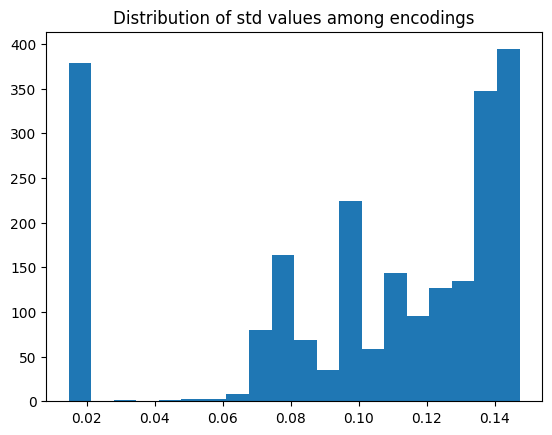

In [75]:
## エンコーディングのstd の分布を見る
import numpy as np
from matplotlib import pyplot as plt

std_dist = [ np.std(x) for x in df['enc'] ]
plt.hist(std_dist, bins = 20)
plt.title(f"Distribution of std values among encodings")
plt.show()
## 0 周辺に事例があるなら，エンコーディング効率が悪い

In [76]:
## 一様分布の事例を除外
import numpy as np

check = False
print(f"{len(df)} instances before filtering")
enc = df['enc']

max_std = max([ np.std(x) for x in enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in enc])))[-1]
print(f"std 2nd min: {second_min_std}")

2268 instances before filtering
std 1st min: 0.014694235151350259
std 2nd min: 0.1472367990881052


In [77]:
## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
import numpy as np

std_threshold = second_min_std / 9 # 穏健な値を得るために9で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
classified = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ classified ]
#
print(f"filtering leaves {len(df_filtered)} instances ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.0163596443431228
filtering leaves 1916 instances (352 instances removed)


In [78]:
## 弱いサンプリング
secondary_sampling = False
if secondary_sampling:
    df = df.sample(round(len(df) * 0.5))
len(df)

2268

In [79]:
df['domain_id'].value_counts().sort_index()

domain_id
0    400
1    400
2    241
3    400
4    400
5    400
6     27
Name: count, dtype: int64

# 次元削減 (tSNE or UMAP)

In [80]:
## tSNE を使った documents のクラスタリング
import numpy as np
if use_tSNE:
    import sklearn.manifold
    ## reload on necessity
    need_reloading = False
    if (need_reloading):
        import importlib
        importlib.reload(sklearn)
    ## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
    relative = True
    if relative:
        doc_perplexity_val = round(len(df) * doc_perplexity_reduct_rate)
    else:
        doc_perplexity_val = 300 # 大き過ぎると良くない
    print(f"doc_perplexity_val: {doc_perplexity_val}")
    ## 3D version
    doc_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                    perplexity = doc_perplexity_val, n_iter = 1000)
    ## データに適用
    E = np.array(list(df['enc']))
    doc_tSNE_3d = doc_tSNE_3d.fit_transform(E)

In [81]:
#!pip3 install -U tdqm
#!conda install umap
#!pip3 uninstall umap -y
#!pip3 install -U umap-learn -y

In [82]:
#!conda install jupyter ipywidgets -y

In [83]:
## UMAP を使った documents のグループ化
import numpy as np
if use_UMAP:
    #import umap # causes a problem
    import umap.umap_ as umap
    ## UMAP の生成
    UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                        metric = umap_metric,
                        n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

    ## データに適用
    doc_UMAP_3d = UMAP_3d.fit_transform(np.array(list(df['enc'])))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Dim Reduct の結果の可視化 (Ploty を使って)

In [84]:
## 使用する embedding の選択
if use_UMAP:
    Fit_3d = doc_UMAP_3d
else:
    Fit_3d = doc_tSNE_3d
## plot_df の定義
import pandas as pd
encoded_df = pd.DataFrame(
    zip(Fit_3d[:,0], Fit_3d[:,1], Fit_3d[:,2], df['domain_id'], df['domain'], df['aberrated'], df[doc_type]),
    columns = ['D1', 'D2', 'D3', 'domain_id', 'domain', 'aberrated', doc_type])
#
encoded_df

,D1,D2,D3,domain_id,domain,aberrated,word
0,8.0062,3.2612,-2.5601,5,cooking,0,豆腐ラーメン
1,-2.5585,-0.5431,9.9417,4,publishing,0,差し替え番号
2,-2.6048,-0.4699,9.8014,3,juridical,0,新株予約権売渡請求
3,4.1862,8.2991,-9.6396,3,juridical,0,金融商品取引業協会
4,7.1275,-3.2331,-5.5536,1,mce,0,運動プログラム
...,...,...,...,...,...,...,...
2263,6.3851,1.9727,-6.9509,0,medical,0,自己免疫性膵炎
2264,-5.9585,-1.3214,-4.9386,1,mce,0,OVER気味
2265,3.4863,-9.2499,0.5139,5,cooking,0,なめろう軍艦
2266,7.8142,13.6719,4.4695,3,juridical,0,担保権の消滅


In [85]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np
#
domain_ids = set(encoded_df['domain_id'])
reverse_domain_list = False
if reverse_domain_list:
    domain_ids = sorted(domain_list, reverse = True)
## layered/traced drawing
fig = go.Figure()
for domain_id in domain_ids:
    # set marker size of the target domain
    if domain_id == [ i for k, v in domain_encoding.items() if k == target_domain ][0]:
        size_val = 5
    else:
        size_val = 3
    part = encoded_df[ encoded_df['domain_id'] == domain_id ]
    color = colormap[domain_id]
    print(f"color: {color}")
    fig.add_trace(
        go.Scatter3d(
            x = part['D1'], y = part['D2'], z = part['D3'],
            name = domain_back_encoding[domain_id],
            mode = 'markers',
            marker = dict(size = size_val, opacity = 0.8),
            #marker_colorscale = list(colormap.values()),
            marker_color = color,
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(df)
if use_UMAP:
    title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
else:
    title_header = f"t-SNE 3D (ppl: {doc_perplexity_val}) of {df_size} encodings of via\n"
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

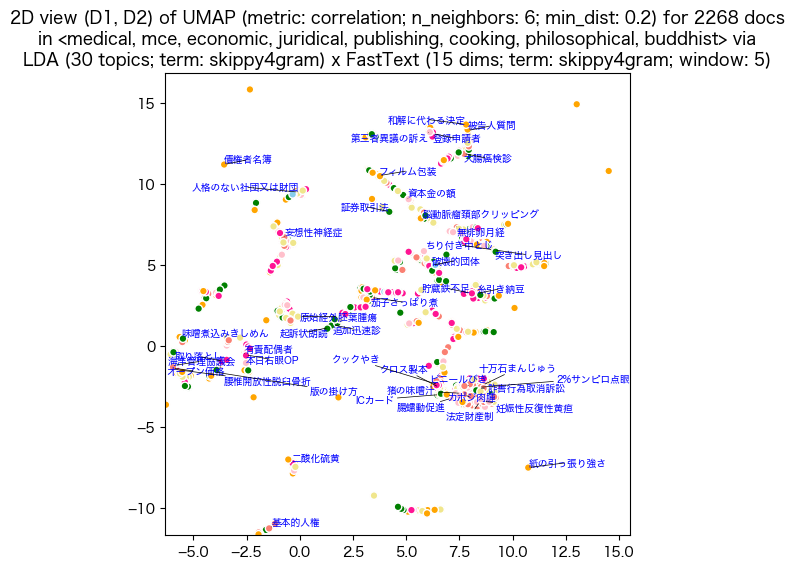

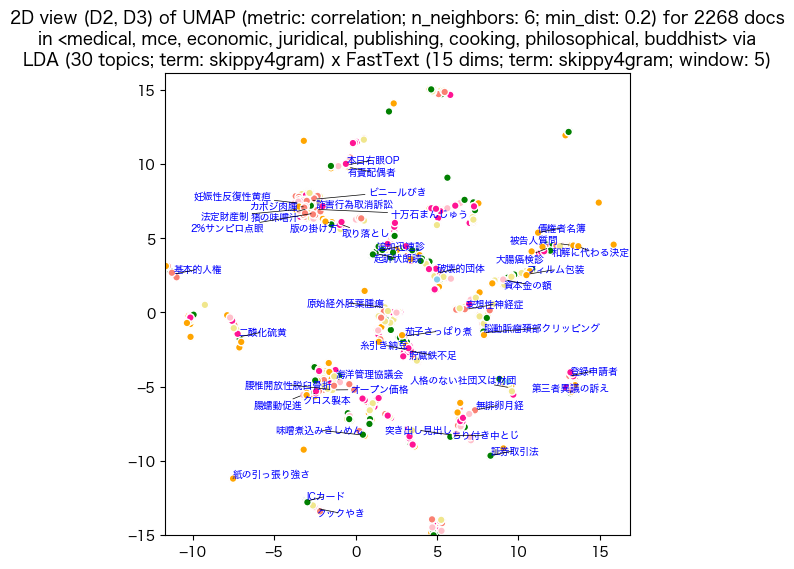

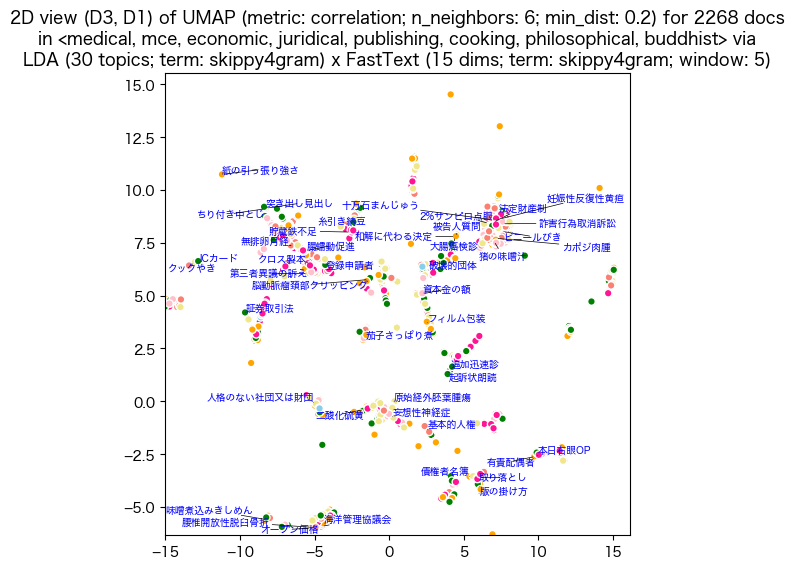

In [86]:
%%capture --no-display
## tSNE の結果の可視化
import matplotlib.pyplot as plt
from adjustText import adjust_text
## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定
## 文字を表示する事例のサンプリング
relative = True
lab_sampling_rate = 0.02 # サンプリング率の指定
if relative:
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定
print(f"lab_sample_n: {lab_sample_n}")
## labels の生成
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]
##
for i in range(3):
    roll = np.roll([0,1,2], -i)
    asp1, asp2 = roll[0], roll[1]
    X, Y = Fit_3d[:, asp1], Fit_3d[:, asp2]
    ## 
    plt.figure(figsize = (6, 6))
    plt.xlim(X.min(), X.max() + 1)
    plt.ylim(Y.min(), Y.max() + 1)
    ## 分野ごとの色分け
    cmap = list(map(lambda i: colormap[i], df['domain_id'])) # colormap は最初に定義してある
    scatter = plt.scatter(X, Y, s = 30, c = cmap, edgecolors = 'w')
    ##
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
    ## label に repel を追加: adjustText package の導入が必要
    get_Float_object_is_not_subsriptable_Error = False
    if get_Float_object_is_not_subsriptable_Error:
        pass
    else:
        try:
            adjust_text(texts,
                    expand_points = (1, 1), expand_text = (1, 1),
                    force_points = 0.2,
                    force_text = 0.2,
                    arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
        except TypeError:
            pass
    ## title piece 1
    if use_UMAP:
        embedding_method = f"UMAP (metric: {umap_metric}; n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist})"
    else:
        embedding_method = f"t-SNE (ppl: {doc_perplexity_val})"
    ## title pice 2
    used_domains = f"<{', '.join(selected_domains.keys())}>"
    ## title_val
    title_header = f"2D view (D{asp1+1}, D{asp2+1}) of {embedding_method} for {len(df)} docs\nin {used_domains} via\n"
    if use_FastText:
        if use_LDA:
            title_val = title_header + f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_val = title_header + f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_val = title_header + f"LDA ({n_topics} topics; term: {lda_term_type})"
    #
    plt.title(title_val)
    plt.show()

# DBSCAN で docs をクラスタリング

In [87]:
## DBSCAN でクラスタリング
from sklearn.cluster import DBSCAN
## source の指定
dbscan_source = Fit_3d
## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2
## looking for optimal eps val compatible with color palette
max_n_clusters = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids = None
print(f"Looking for the optimal eps val...")
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    if verbose:
        print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    if verbose:
        print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
final result: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [88]:
## 必要に応じて Seaborn を道入
#!pip install -U seaborn
#!pip install -U adjustText

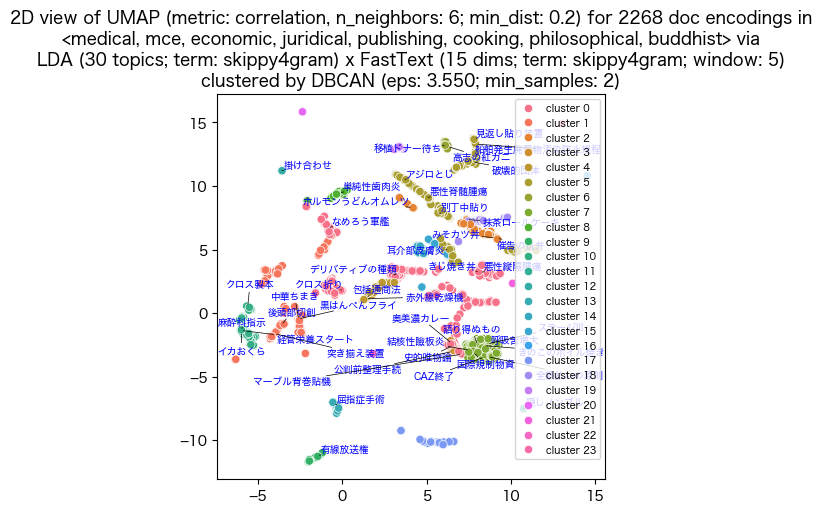

In [89]:
%%capture --no-display
import seaborn as sns
import matplotlib.pyplot as plt
## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定
## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)
## 描画
fig = plt.figure(figsize = (5, 5))
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}"
    for l in dbscan_clustered.labels_ ]) # requires Searborn
## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.02 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定
## 事例名の生成
texts = [ ]
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2),
        #expand_points = (1, 1),
        #expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_domains = f"<{', '.join(selected_domains.keys())}>"
## title_header
df_size = len(df)
if use_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} doc encodings in\n{used_domains} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} document encodings in\n{used_domains} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

In [90]:
## co-clusteredness に基づく領域間類似度の計算
import pandas as pd
from sklearn.cluster import DBSCAN
if use_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d
## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2
## co-clustering correlation の精度を上げるために，クラスター数を多目にする
scaling_factor = 5 # 4 は必須
max_n_clusters_for_correl = round(len(selected_domains) * scaling_factor)
print(f"max_n_clusters_for_correl")
print(f"Looking for the optimal value for eps...")
check = False
x_dbscan_clustered = None
x_cluster_ids = None
max_val = 10 # needs to be effectively large
eps_vals = np.arange(max_val, 0.01, -0.01)
eps_val_final = None
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    x_dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    x_cluster_ids_local = x_dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(x_cluster_ids_local)}")
    try:
        assert len(np.unique(x_cluster_ids_local)) <= max_n_clusters_for_correl
        eps_val_final = eps_val
        x_dbscan_clustered = x_dbscan_clustered_local
        x_cluster_ids = x_cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(x_cluster_ids)}")
## clusterごとに分野の帰属数を集計 
selector_var = 'domain'
bindings = zip(encoded_df[doc_type], encoded_df[selector_var], x_dbscan_clustered.labels_)
binding_df = pd.DataFrame(bindings, columns = [doc_type, selector_var, 'cluster'])
selector_names = sorted(set(binding_df[selector_var]))
print(f"selector_names: {selector_names}")
cluster_ids = sorted(set(binding_df['cluster']))
print(f"cluster ids: {cluster_ids}")
clusterwise_counts = { selector_name : None for selector_name in selector_names }
for selector_name in selector_names:
    counts = [ ]
    selected = binding_df[ binding_df[selector_var] == selector_name ]
    for i, cluster_id in enumerate(cluster_ids):
        matched = selected[ selected['cluster'] == cluster_id ]
        n_matches = len(matched)
        if n_matches == 0:
            counts.append(0)
        else:
            counts.append(int(n_matches))
    clusterwise_counts[selector_name] = counts
## クラスターでの生起個数の間の相関を計算
clusterwise_counts_df = pd.DataFrame.from_dict(clusterwise_counts) ## Truly versatile
clusterwise_counts_df

max_n_clusters_for_correl
Looking for the optimal value for eps...
final result: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
selector_names: ['cooking', 'economic', 'juridical', 'mce', 'medical', 'philosophical', 'publishing']
cluster ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


,cooking,economic,juridical,mce,medical,philosophical,publishing
0,12,4,6,11,30,5,8
1,6,11,13,8,13,0,9
2,3,1,8,0,0,0,10
3,37,26,34,28,58,5,38
4,3,1,7,11,7,0,9
5,9,2,5,7,25,0,27
6,27,13,23,14,11,1,28
7,12,6,7,7,7,0,10
8,61,60,16,144,79,6,13
9,8,9,14,8,15,0,10


Heatmap で co-clusteredness 相関を可視化

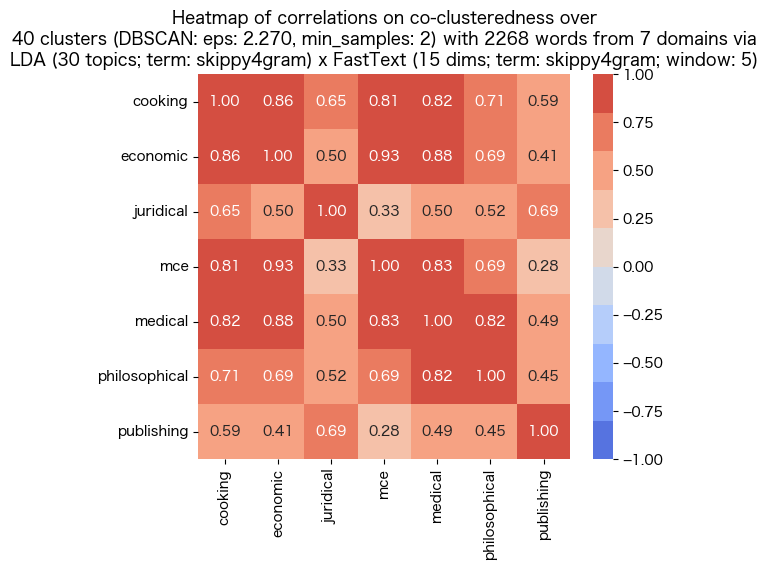

In [91]:
## Heatmap で可視化
import seaborn as sns
counts_df_normalized = (clusterwise_counts_df - clusterwise_counts_df.min())/(clusterwise_counts_df.max() - clusterwise_counts_df.min())
corr_df = counts_df_normalized.corr()
#corr_df.sort_index(axis = 0, inplace = True)
#corr_df.sort_index(axis = 1, inplace = True)
n_selectors = len(selector_names)
fig = plt.figure(figsize = (round(n_selectors * 0.9), round(n_selectors * 0.7)))
sns.heatmap(corr_df, cmap = sns.color_palette('coolwarm', 10),
            annot = True, fmt = '.2f', vmin = -1, vmax = 1)

title_header = f"Heatmap of correlations on co-clusteredness over\n{len(cluster_ids)} clusters (DBSCAN: eps: {eps_val_final:0.3f}, min_samples: {min_samples_val}) with {len(dbscan_source)} {doc_type}s from {n_selectors} {selector_var}s via\n"
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term_type: {lda_term_type})"
title_val = title_header + title_body
plt.title(title_val)
plt.show()

# 階層クラスタリングのための再サンプリング

In [92]:
## 階層クラスタリングのための事例サンプリング
hc_sampling_rate = 0.1 # 変更可能: 大きくし過ぎると図が見にくい
df_size = len(df_filtered)
if df_size > 600:
    hc_df_sampled = df_filtered.sample(round(df_size * hc_sampling_rate), replace = False)
    hc_df_sampled = hc_df_sampled.drop_duplicates(['word'])
else:
    hc_df_sampled = df_filtered
##
print(f"{len(hc_df_sampled)} rows are sampled (preserve rate: {len(hc_df_sampled)/len(df_filtered):0.3f})")

185 rows are sampled (preserve rate: 0.097)


In [93]:
## HCデータの保存
if save_df_sampled:
    import datetime as dt
    ct = dt.datetime.now()
    ## Pandas で .csv として
    import pandas as pd
    # .csv 
    output_as_csv = f"saves/df_sampled-{ct.date()}-{str(ct.time())[:2]}" + ".csv"
    print(f"saving data to {output_as_csv}")
    hc_df_sampled.to_csv(output_as_csv, encoding = "utf-8")
    # .xlsx
    output_as_xlsx = f"saves/df_sampled-{ct.date()}-{str(ct.time())[:2]}" + ".xlsx"
    print(f"saving data to {output_as_xlsx}")
    hc_df_sampled.to_excel(output_as_xlsx)
    ## pickle.dump(..)で
    output_fn2 = f"saves/df_sampled-{ct.date()}-{str(ct.time())[:2]}" + ".p"
    import pickle
    print(f"saving data to {output_fn2}")
    with open(output_fn2, "wb") as f:
        pickle.dump(hc_df_sampled, f)

In [94]:
## domain 事例数の確認
hc_df_sampled['domain'].value_counts(sort = True).sort_index()

domain
cooking          37
economic         20
juridical        36
mce              30
medical          28
philosophical     1
publishing       33
Name: count, dtype: int64

階層クラスタリング

In [95]:
## plotly が必要な場合に実行
#!pip install -U plotly

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_7101/628701534.py:49: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



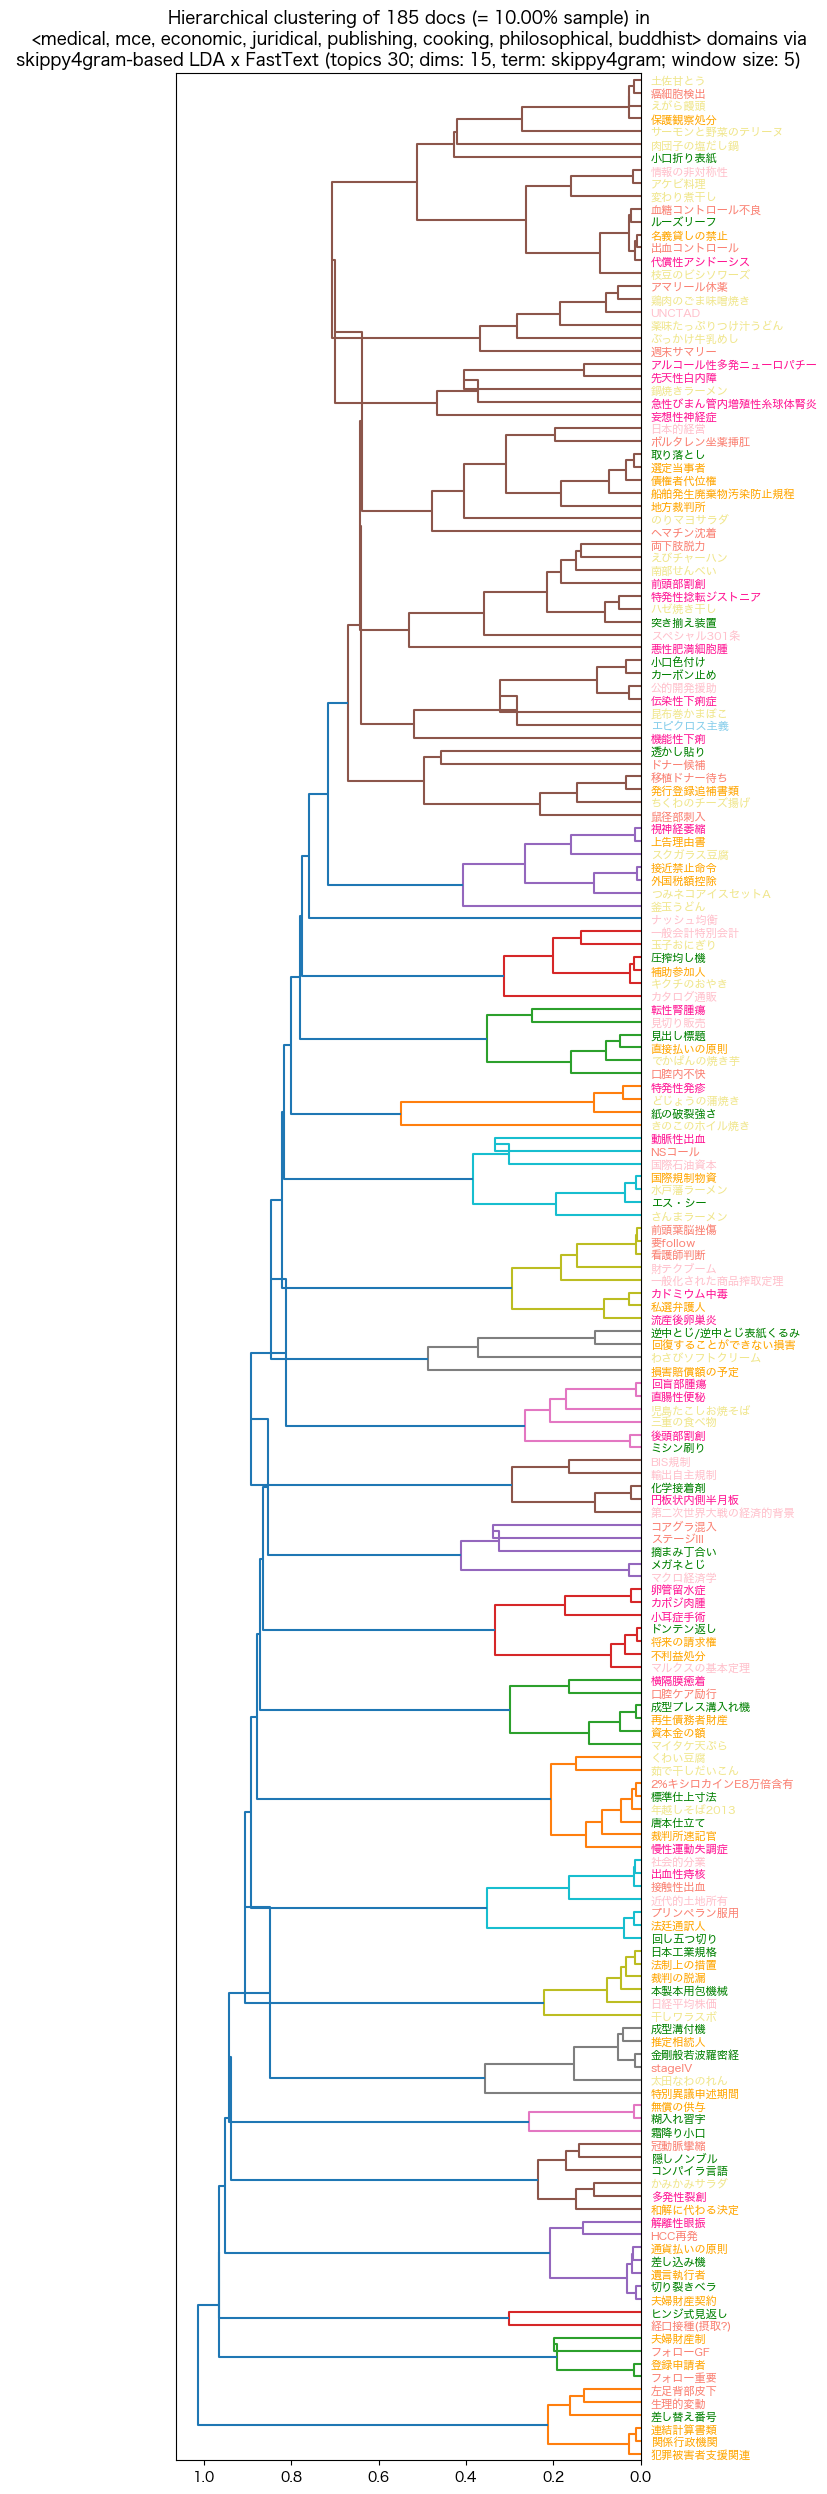

In [96]:
## doc 階層クラスタリングの実行
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.cluster.hierarchy import dendrogram, linkage
## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定
## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(hc_df_sampled) * 0.017))) # This needs to be run here, before dendrogram construction.
## 距離行列の構築
linkage_methods = [ 'centroid', 'median', 'ward' ]
linkage_method = linkage_methods[1]
#
doc_linkage = linkage(list(hc_df_sampled['enc']),
                      method = linkage_method, metric = 'euclidean')
## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(hc_df_sampled[doc_type]) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 題の指定
df_size = len(hc_df_sampled)
sampling_rate = f"{100 * hc_sampling_rate:.2f}"
domain_names = ', '.join(selected_domains.keys())
title_body = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample) in\n\
    <{domain_names}> domains via\n"
if use_FastText:
    if use_LDA:
        title_val = title_body + f"{lda_term_type}-based {encoding_method} (topics {n_topics}; dims: {ft_n_dims}, term: {ft_term_type}; window size: {ft_window_size})"
    else:
        title_val = title_body + f"{encoding_method} (dims: {n_topics}, term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = title_body + f"{lda_term_type}-based {encoding_method} ({n_topics} topics)"
plt.title(title_val)

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    ## filter matched rows
    matched_rows = hc_df_sampled.loc[hc_df_sampled[doc_type] == word]
    if len(matched_rows) == 1:
        row = matched_rows
    else:
        #row = matched_rows[0] #fails to work?
        row = matched_rows.iloc[0] # matched_rows[0] fails to work
    ## extract domain_id value
    try:
        domain_id = int(row['domain_id'])
        ticker.set_color(colormap[domain_id]) # id の基数調整
    except TypeError:
        pass
#
plt.show()

In [97]:
## aberrated の混ざったdoc 階層クラスタリングの実行
aberrations = hc_df_sampled[hc_df_sampled['aberrated'] == 1][doc_type]
print(aberrations)

23      急性びまん管内増殖性糸球体腎炎
1057              転性腎腫瘍
Name: word, dtype: object


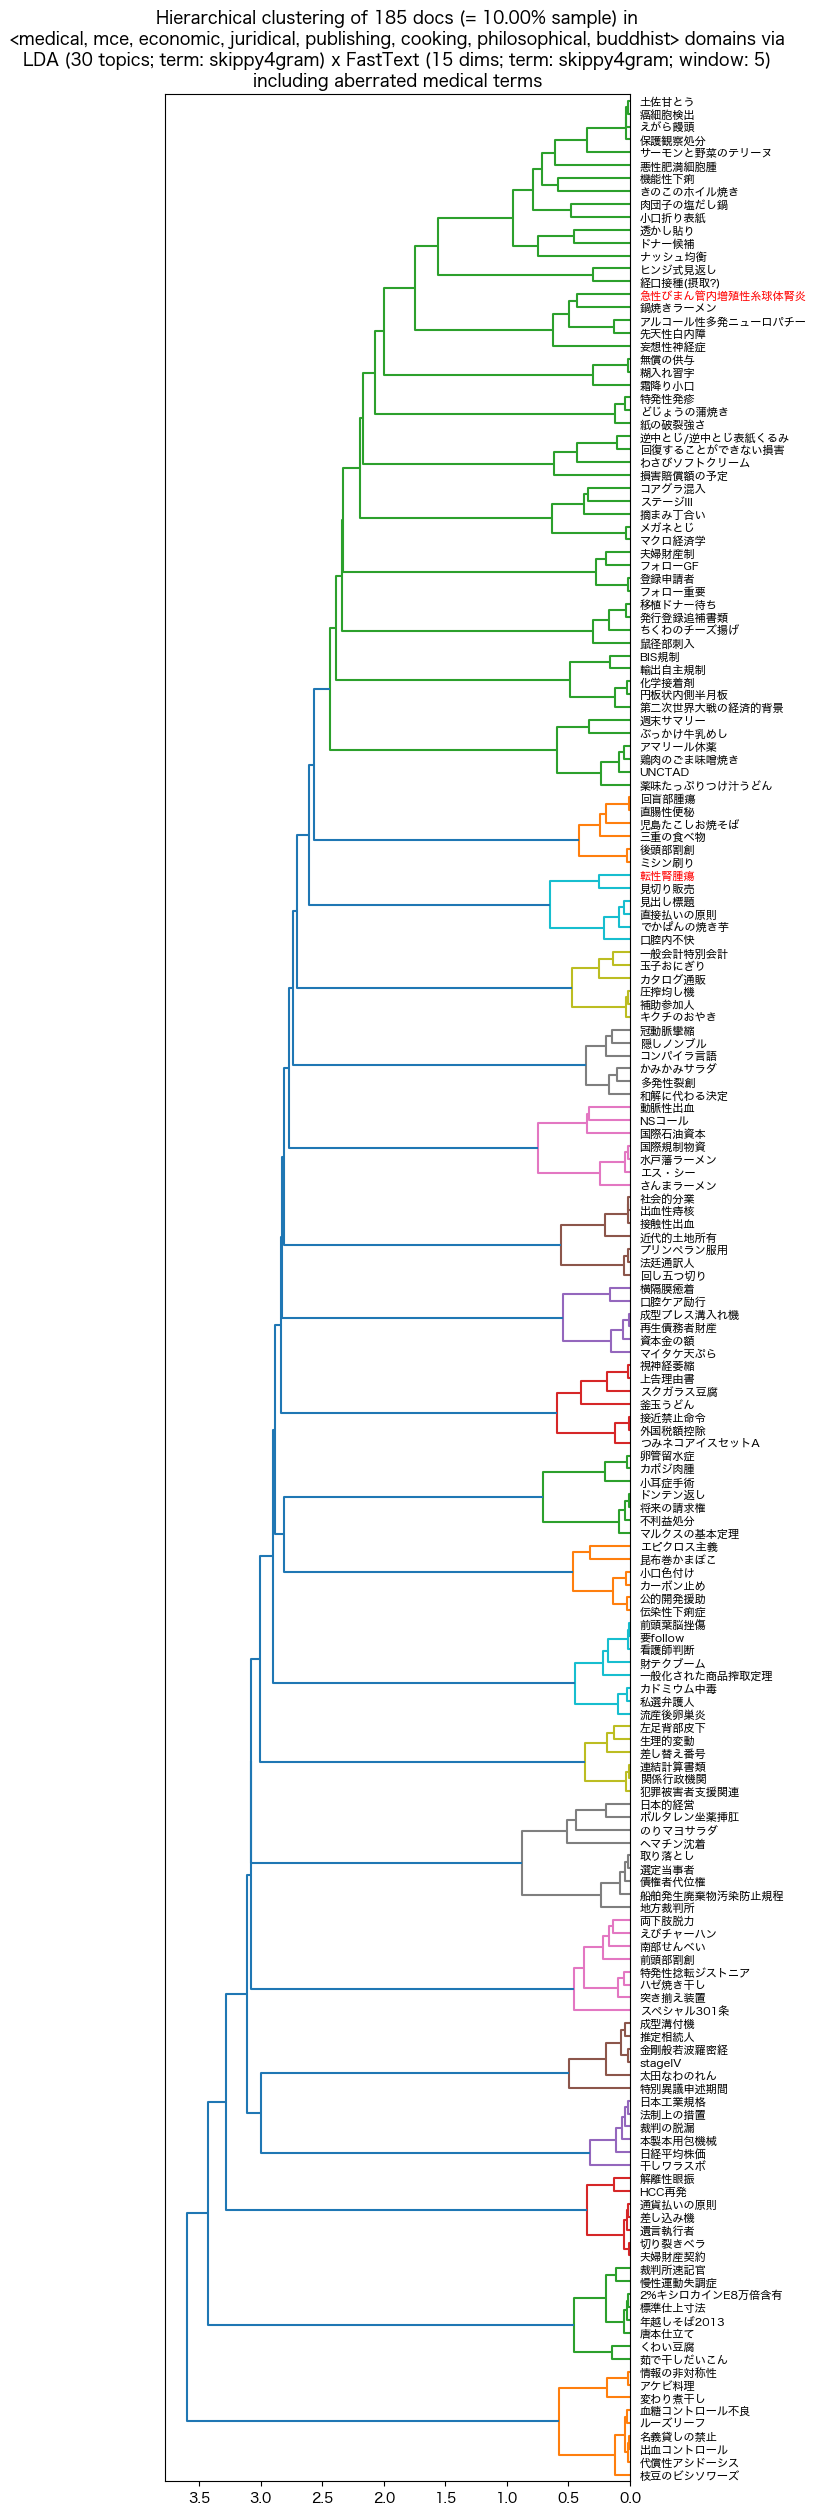

In [98]:
## 逸脱ありdoc 階層クラスタリングの実行
if len(aberrations) == 0:
    exit(0)
##
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.cluster.hierarchy import dendrogram, linkage
## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定
## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(hc_df_sampled) * 0.017))) # This needs to be run here, before dendrogram construction.
## 距離行列の構築
doc_linkage = linkage(list(hc_df_sampled['enc']), method = 'ward', metric = 'euclidean')
## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(hc_df_sampled[doc_type]) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)
## 題の指定
df_size = len(hc_df_sampled)
sampling_rate = f"{100 * hc_sampling_rate:.2f}"
domain_names = ', '.join(selected_domains.keys())
title_header = f"Hierarchical clustering of {df_size} docs (= {sampling_rate}% sample) in\n<{domain_names}> domains via\n" 
title_tail = f"\nincluding aberrated medical terms"
if use_FastText:
    if use_LDA:
        title_val = title_header + f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})" + title_tail
    else:
        title_val = title_header + f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})" + title_tail
else:
    title_val = title_header + f"LDA ({n_topics} topics; term: {lda_term_type})" + title_tail
plt.title(title_val)
## aberrated == 1 の事例を色分けする
ax = plt.gca()
check = False
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    if check:
        print(f"word: {word}")
    if word in set(aberrations):
        if check:
            print(f"aberrated word:{word}")
        ticker.set_color('red')
#
plt.show()

# Terms のエンコードとクラスタリング

In [99]:
## term のLDA モデルを使ったエンコード
## get_term_topics(..) では　minimu_probability = 0 としてもprobabaly = 0 の topic IDs が
## 得られないので，sparse encoding しか得られない
lda_term_sparse_enc = { term : { x[0] : x[1] for x in doc_lda.get_term_topics(tid, minimum_probability = 0) } for tid, term in diction.items() }
## check
pp.pprint(random.sample(lda_term_sparse_enc.items(), 3))
print(f"Number of terms: {len(lda_term_sparse_enc)}")

[('防護…章…録',
  {2: 2.6081232e-05,
   3: 1.7297834e-08,
   7: 1.3559054e-05,
   10: 9.8294595e-06,
   14: 1.0326493e-07}),
 ('犯…関',
  {4: 3.3184758e-06,
   5: 4.1969433e-06,
   8: 0.00033757932,
   10: 2.62359e-05,
   16: 2.3520456e-06,
   18: 2.7226245e-06}),
 ('在留…セン', {9: 2.4019238e-08, 13: 2.8765037e-08})]
Number of terms: 20098


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_7101/792626229.py:6: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.



In [100]:
## pandas を使って sparse_enc を full enc に変換
lda_term_enc_df = pd.DataFrame.from_dict( { k : pd.Series(v) for k, v in
                                                lda_term_sparse_enc.items()} )
## 上で生じたNaN を0に変換
lda_term_enc_df = lda_term_enc_df.fillna(0)    
## データを転地
lda_term_enc_df = lda_term_enc_df.transpose()
lda_term_enc_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
ラ…メ,0.0,0.0,2.5997e-05,0.0,0.0,0.0,8.0123e-06,0.0,0.0,3.9512e-05,...,3.2356e-05,0.0,2.9650e-05,0.0,0.0,2.7847e-05,0.0001,0.0,0.0,0.0
ラーメ,0.0,0.0,2.6043e-05,0.0,0.0,0.0,8.0271e-06,0.0,0.0,3.9311e-05,...,3.2429e-05,0.0,2.9528e-05,0.0,0.0,3.1837e-05,0.0001,0.0,0.0,0.0
ラーメン,0.0,0.0,2.6022e-05,0.0,0.0,0.0,8.0226e-06,0.0,0.0,3.9470e-05,...,3.2431e-05,0.0,2.9533e-05,0.0,0.0,2.9934e-05,0.0001,0.0,0.0,0.0
ーメン,0.0,0.0,2.6025e-05,0.0,0.0,0.0,7.9913e-06,0.0,0.0,3.9614e-05,...,3.2394e-05,0.0,2.9398e-05,0.0,0.0,3.5007e-05,0.0001,0.0,0.0,0.0
豆…メ,0.0,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0,0.0000e+00,...,0.0000e+00,0.0,0.0000e+00,0.0,0.0,0.0000e+00,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
被申立,0.0,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0,0.0000e+00,...,0.0000e+00,0.0,0.0000e+00,0.0,0.0,0.0000e+00,0.0000,0.0,0.0,0.0
被申立…保,0.0,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0,0.0000e+00,...,0.0000e+00,0.0,0.0000e+00,0.0,0.0,0.0000e+00,0.0000,0.0,0.0,0.0
被申立…権,0.0,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0,0.0000e+00,...,0.0000e+00,0.0,0.0000e+00,0.0,0.0,0.0000e+00,0.0000,0.0,0.0,0.0
被申立…者,0.0,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0,0.0000e+00,...,0.0000e+00,0.0,0.0000e+00,0.0,0.0,0.0000e+00,0.0000,0.0,0.0,0.0


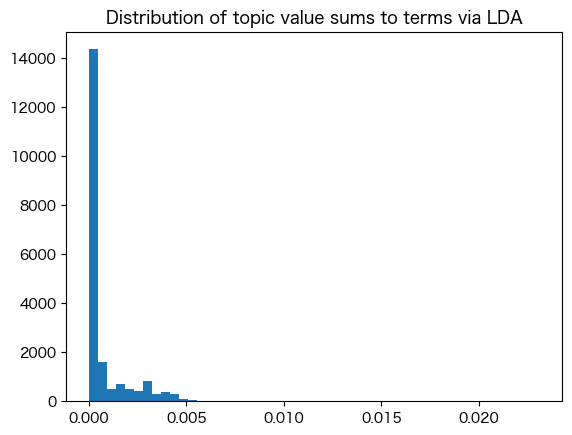

In [101]:
## term のtopic の総和の分布を見る
import matplotlib.pyplot as plt
plt.hist(lda_term_enc_df.sum(axis = 1), bins = 50)
plt.title(f"Distribution of topic value sums to terms via LDA")
plt.show()

In [102]:
## filtering terms: density で filtering
size0 = len(lda_term_enc_df)
lowest_density = 0.0001
lda_term_enc_df_filtered = lda_term_enc_df[ lda_term_enc_df.sum(axis = 1) > lowest_density ]
size1 = len(lda_term_enc_df_filtered)
print(f"{size1} rows remain, discarding {size0 - size1} rows")

7628 rows remain, discarding 12470 rows


In [103]:
## sampling term_enc_df for hc
term_hc_sampling_rate = 0.03
sampled_term_enc_df = \
    lda_term_enc_df_filtered.sample(round(len(lda_term_enc_df_filtered) * term_hc_sampling_rate))
#
sampled_term_enc_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
性膵炎,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0000e+00,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000e+00,4.4666e-03
り出…切り,0.0,0.0000e+00,0.0,0.0,0.0,1.7172e-05,0.0000e+00,0.0000e+00,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000e+00,0.0000e+00
/逆…じ…く,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,1.1016e-04,0.0000e+00,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,4.2768e-04,0.0000e+00
野…ー,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0000e+00,3.6576e-05,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000e+00,0.0000e+00
使用権,0.0,2.7806e-05,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0000e+00,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000e+00,0.0000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
特…の…取特,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0000e+00,0.0,0.0000,...,0.0001,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.2655e-07,0.0000e+00
登…定機関,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0000e+00,0.0,0.0004,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000e+00,0.0000e+00
社会…義…済,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0000e+00,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000e+00,0.0000e+00
カ…丼,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0000e+00,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,0.0000e+00,2.8742e-05


In [104]:
## term length で filtering
min_length = 2
max_length = 4
len_filter = [ len(x) >= min_length and len(x) <= max_length for x in sampled_term_enc_df.index ]
sampled_term_enc_df = sampled_term_enc_df[len_filter]
size2 = len(sampled_term_enc_df)
print(f"{size2} rows remain, discarding {size1 - size2} rows")
#
sampled_term_enc_df

108 rows remain, discarding 7520 rows


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
性膵炎,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0000e+00,0.0000e+00,0.0,...,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0,0.0000,0.0000,0.0,4.4666e-03
野…ー,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,3.6576e-05,0.0000e+00,0.0,...,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0,0.0000,0.0000,0.0,0.0000e+00
使用権,0.0,2.7806e-05,0.0,0.0,0.0,0.0000e+00,0.0,0.0000e+00,0.0000e+00,0.0,...,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0,0.0000,0.0000,0.0,0.0000e+00
ンダー金,0.0,0.0000e+00,0.0,0.0,0.0,2.8112e-03,0.0,0.0000e+00,0.0000e+00,0.0,...,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0,0.0000,0.0000,0.0,0.0000e+00
ア…ッ,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0000e+00,0.0000e+00,0.0,...,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0,0.0031,0.0000,0.0,0.0000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
決…続,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,3.4538e-05,0.0000e+00,0.0,...,0.0,0.0,0.0,0.0000e+00,0.0000e+00,0.0,0.0000,0.0000,0.0,0.0000e+00
限…為,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0000e+00,0.0000e+00,0.0,...,0.0,0.0,0.0,2.9887e-03,0.0000e+00,0.0,0.0000,0.0000,0.0,0.0000e+00
定当事,0.0,0.0000e+00,0.0,0.0,0.0,0.0000e+00,0.0,0.0000e+00,3.4564e-05,0.0,...,0.0,0.0,0.0,3.1661e-03,0.0000e+00,0.0,0.0000,0.0000,0.0,0.0000e+00
の…え,0.0,1.2626e-04,0.0,0.0,0.0,3.4145e-05,0.0,0.0000e+00,0.0000e+00,0.0,...,0.0,0.0,0.0,9.7914e-08,1.3095e-05,0.0,0.0000,0.0049,0.0,4.0007e-05


Term の階層クラスタリング

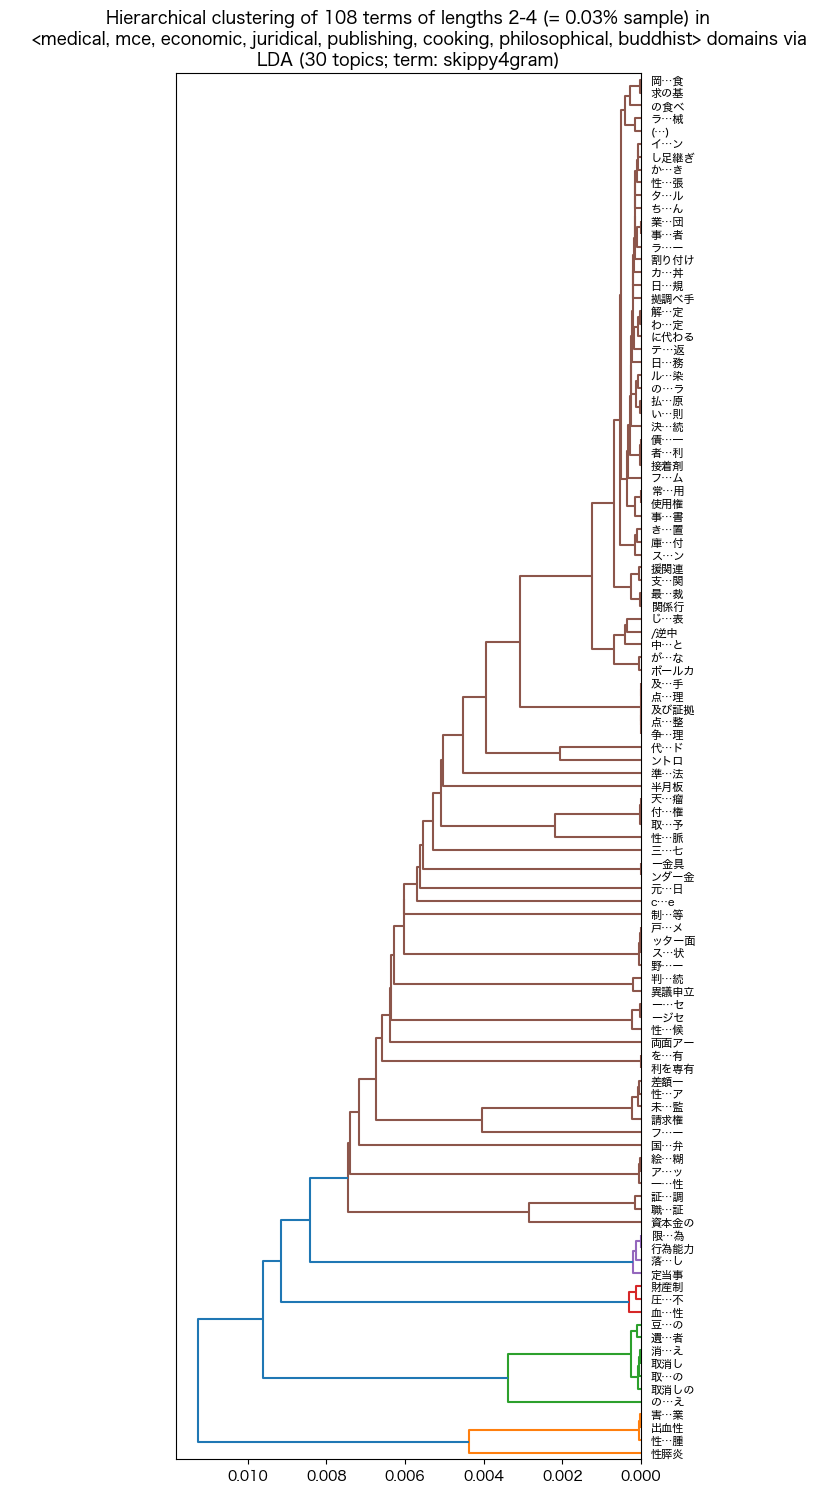

In [105]:
## term の階層クラスタリングの実行

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定

## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(sampled_term_enc_df) * 0.017))) # This needs to be run here, before dendrogram construction.

## 距離行列の構築
linkage_methods = [ 'centroid', 'median', 'ward' ]
linkage_method = linkage_methods[-1]
term_linkage = linkage(sampled_term_enc_df, method = linkage_method, metric = 'euclidean')

## 事例ラベルの生成
max_term_length = max([ len(x) for x in list(sampled_term_enc_df.index)])
label_vals = [ x[:max_term_length] for x in list(sampled_term_enc_df.index) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(term_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 題の指定
term_df_size = len(sampled_term_enc_df)
sampling_rate = f"{100 * term_hc_sampling_rate:.2f}"
domain_names = ', '.join(selected_domains.keys())
title_header = f"Hierarchical clustering of {term_df_size} terms of lengths {min_length}-{max_length} (= {term_hc_sampling_rate}% sample) in\n\
    <{domain_names}> domains via\n"
title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
title_val = title_header + title_body
plt.title(title_val)
plt.show()